In [1]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torchvision import datasets
from torchvision import transforms
import numpy as np
#import input_data
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
from DirLPA_utils import *
import matplotlib.pyplot as plt

import os
#import ssms

#s = 123
#np.random.seed(s)
#torch.manual_seed(s)
#torch.cuda.manual_seed(s)

# Load trained Densenet for Imagenet

In [2]:
#load imagenet
imagenet_train_root = os.path.abspath('/media/marius/2e21db24-75e5-4af2-97c9-ad76aadaa247/marius/data/imagenet/ILSVRC2012_img_train')
imagenet_val_root = os.path.abspath('/media/marius/2e21db24-75e5-4af2-97c9-ad76aadaa247/marius/data/imagenet/ILSVRC2012_img_val')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

transform_imagenet_train = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

transform_imagenet_val =  transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

imagenet_train = datasets.ImageFolder(imagenet_train_root, transform=transform_imagenet_train)
imagenet_val = datasets.ImageFolder(imagenet_val_root, transform=transform_imagenet_val)

#print(imagenet_train[0])

batch_size=64

train_loader = torch.utils.data.DataLoader(
        imagenet_train,
        batch_size=batch_size,
        shuffle=True)

val_loader = torch.utils.data.DataLoader(
        imagenet_val,
        batch_size=batch_size)

In [3]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torchvision.models.utils import load_state_dict_from_url
from torch import Tensor
#from torch.jit.annotations import List


__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']

model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    #@torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(*inputs)

        return cp.checkpoint(closure, input)

    #@torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    #@torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2
    __constants__ = ['layers']

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    __constants__ = ['features']

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.phi(x)
        out = self.classifier(out)
        return out
    
    def phi(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        
        return(out)


def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained=False, progress=True, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)

In [4]:
#load densenet

densenet = densenet121(pretrained=True).cuda()
densenet.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
#test inception on the training and testset and check accuracies

def eval_imagenet():
    
    densenet.eval()
    correct = 0
    total = 0

    max_idx = len(val_loader)

    imagenet_MAP = []
    for batch_idx, (x,y) in enumerate(val_loader):
        x,y = x.cuda(), y.cuda()
        pred_ = densenet(x).detach()
        probs = torch.softmax(pred_, dim=1)
        imagenet_MAP.append(probs)
        prob_max, pred = probs.max(1)
        correct += torch.sum(torch.eq(pred, y)).item()
        total += len(y)
        #print(prob, pred, y)
        #print(correct, total)
        print("batch {} of {}".format(batch_idx, max_idx))

    print("accuracy on the validation set: {:.03f}".format(correct/total))
    imagenet_MAP = torch.cat(imagenet_MAP)
    return(imagenet_MAP)

In [6]:
"""
imagenet_MAP = eval_imagenet()
targets = np.array(imagenet_val.targets)
prob_MAP, pred_MAP = imagenet_MAP.max(1)
pred_MAP = pred_MAP.cpu().numpy()
np.equal(targets, pred_MAP).mean()
#"""

'\nimagenet_MAP = eval_imagenet()\ntargets = np.array(imagenet_val.targets)\nprob_MAP, pred_MAP = imagenet_MAP.max(1)\npred_MAP = pred_MAP.cpu().numpy()\nnp.equal(targets, pred_MAP).mean()\n#'

In [7]:
"""
imagenet_MAP_dict = {
    'imagenet_MAP':imagenet_MAP
}

IMAGENET_MAP_PATH = 'weights/imagenet_MAP.pth'
torch.save(imagenet_MAP_dict, IMAGENET_MAP_PATH)
#"""

"\nimagenet_MAP_dict = {\n    'imagenet_MAP':imagenet_MAP\n}\n\nIMAGENET_MAP_PATH = 'weights/imagenet_MAP.pth'\ntorch.save(imagenet_MAP_dict, IMAGENET_MAP_PATH)\n#"

In [8]:
IMAGENET_MAP_PATH = 'weights/imagenet_MAP.pth'
imagenet_MAP_dict = torch.load(IMAGENET_MAP_PATH)
imagenet_MAP = imagenet_MAP_dict['imagenet_MAP']
print(imagenet_MAP.size())

#check accuracy
targets = np.array(imagenet_val.targets)
prob_MAP, pred_MAP = imagenet_MAP.max(1)
pred_MAP = pred_MAP.cpu().numpy()
np.equal(targets, pred_MAP).mean()

torch.Size([50000, 1000])


0.74434

# try to approximate the diagonal Hessian of the Network

In [9]:
def Diag_second_order(model, train_loader, var0 = 10, device='cpu'):

    W = list(model.parameters())[-2]
    b = list(model.parameters())[-1]
    m, n = W.shape
    print("n: {} inputs to linear layer with m: {} classes".format(n, m))
    lossfunc = torch.nn.CrossEntropyLoss()

    tau = 1/var0

    extend(lossfunc, debug=False)
    extend(model.classifier, debug=False)

    with backpack(DiagHessian()):

        max_len = len(train_loader)
        weights_cov = torch.zeros(m, n, device=device)
        biases_cov = torch.zeros(m, device=device)

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.cuda(), y.cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                W_ = W.diag_h
                b_ = b.diag_h
                
            #add_prior: since it will be flattened later we can just add the prior like that
            W_ += tau * torch.ones(W_.size(), device=device)
            b_ += tau * torch.ones(b_.size(), device=device)

            rho = min(1-1/(batch_idx+1), 0.995)
            #rho = 1 - 1/(batch_idx + 1)
            print("rho: ", rho)
                
            weights_cov = rho * weights_cov + (1-rho) * W_
            biases_cov = rho * biases_cov + (1-rho) * b_

            print("Batch: {}/{}".format(batch_idx, max_len))

    # Predictive distribution
    with torch.no_grad():
        M_W_post = W.t()
        M_b_post = b

        C_W_post = weights_cov
        C_b_post = biases_cov
    
        print("M_W_post size: ", M_W_post.size())
        print("M_b_post size: ", M_b_post.size())
        print("C_W_post size: ", C_W_post.size())
        print("C_b_post size: ", C_b_post.size())

    return(M_W_post, M_b_post, C_W_post, C_b_post)

In [10]:
#"""
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=densenet,
                                                               train_loader=train_loader,
                                                               var0 = 1000000000,
                                                               device='cuda')
#"""                                                          

n: 1024 inputs to linear layer with m: 1000 classes
rho:  0.0
Batch: 0/20019
rho:  0.5
Batch: 1/20019
rho:  0.6666666666666667
Batch: 2/20019
rho:  0.75
Batch: 3/20019
rho:  0.8
Batch: 4/20019
rho:  0.8333333333333334
Batch: 5/20019
rho:  0.8571428571428572
Batch: 6/20019
rho:  0.875
Batch: 7/20019
rho:  0.8888888888888888
Batch: 8/20019
rho:  0.9
Batch: 9/20019
rho:  0.9090909090909091
Batch: 10/20019
rho:  0.9166666666666666
Batch: 11/20019
rho:  0.9230769230769231
Batch: 12/20019
rho:  0.9285714285714286
Batch: 13/20019
rho:  0.9333333333333333
Batch: 14/20019
rho:  0.9375
Batch: 15/20019
rho:  0.9411764705882353
Batch: 16/20019
rho:  0.9444444444444444
Batch: 17/20019
rho:  0.9473684210526316
Batch: 18/20019
rho:  0.95
Batch: 19/20019
rho:  0.9523809523809523
Batch: 20/20019
rho:  0.9545454545454546
Batch: 21/20019
rho:  0.9565217391304348
Batch: 22/20019
rho:  0.9583333333333334
Batch: 23/20019
rho:  0.96
Batch: 24/20019
rho:  0.9615384615384616
Batch: 25/20019
rho:  0.96296296296

rho:  0.995
Batch: 205/20019
rho:  0.995
Batch: 206/20019
rho:  0.995
Batch: 207/20019
rho:  0.995
Batch: 208/20019
rho:  0.995
Batch: 209/20019
rho:  0.995
Batch: 210/20019
rho:  0.995
Batch: 211/20019
rho:  0.995
Batch: 212/20019
rho:  0.995
Batch: 213/20019
rho:  0.995
Batch: 214/20019
rho:  0.995
Batch: 215/20019
rho:  0.995
Batch: 216/20019
rho:  0.995
Batch: 217/20019
rho:  0.995
Batch: 218/20019
rho:  0.995
Batch: 219/20019
rho:  0.995
Batch: 220/20019
rho:  0.995
Batch: 221/20019
rho:  0.995
Batch: 222/20019
rho:  0.995
Batch: 223/20019
rho:  0.995
Batch: 224/20019
rho:  0.995
Batch: 225/20019
rho:  0.995
Batch: 226/20019
rho:  0.995
Batch: 227/20019
rho:  0.995
Batch: 228/20019
rho:  0.995
Batch: 229/20019
rho:  0.995
Batch: 230/20019
rho:  0.995
Batch: 231/20019
rho:  0.995
Batch: 232/20019
rho:  0.995
Batch: 233/20019
rho:  0.995
Batch: 234/20019
rho:  0.995
Batch: 235/20019
rho:  0.995
Batch: 236/20019
rho:  0.995
Batch: 237/20019
rho:  0.995
Batch: 238/20019
rho:  0.995
Ba

rho:  0.995
Batch: 488/20019
rho:  0.995
Batch: 489/20019
rho:  0.995
Batch: 490/20019
rho:  0.995
Batch: 491/20019
rho:  0.995
Batch: 492/20019
rho:  0.995
Batch: 493/20019
rho:  0.995
Batch: 494/20019
rho:  0.995
Batch: 495/20019
rho:  0.995
Batch: 496/20019
rho:  0.995
Batch: 497/20019
rho:  0.995
Batch: 498/20019
rho:  0.995
Batch: 499/20019
rho:  0.995
Batch: 500/20019
rho:  0.995
Batch: 501/20019
rho:  0.995
Batch: 502/20019
rho:  0.995
Batch: 503/20019
rho:  0.995
Batch: 504/20019
rho:  0.995
Batch: 505/20019
rho:  0.995
Batch: 506/20019
rho:  0.995
Batch: 507/20019
rho:  0.995
Batch: 508/20019
rho:  0.995
Batch: 509/20019
rho:  0.995
Batch: 510/20019
rho:  0.995
Batch: 511/20019
rho:  0.995
Batch: 512/20019
rho:  0.995
Batch: 513/20019
rho:  0.995
Batch: 514/20019
rho:  0.995
Batch: 515/20019
rho:  0.995
Batch: 516/20019
rho:  0.995
Batch: 517/20019
rho:  0.995
Batch: 518/20019
rho:  0.995
Batch: 519/20019
rho:  0.995
Batch: 520/20019
rho:  0.995
Batch: 521/20019
rho:  0.995
Ba

rho:  0.995
Batch: 771/20019
rho:  0.995
Batch: 772/20019
rho:  0.995
Batch: 773/20019
rho:  0.995
Batch: 774/20019
rho:  0.995
Batch: 775/20019
rho:  0.995
Batch: 776/20019
rho:  0.995
Batch: 777/20019
rho:  0.995
Batch: 778/20019
rho:  0.995
Batch: 779/20019
rho:  0.995
Batch: 780/20019
rho:  0.995
Batch: 781/20019
rho:  0.995
Batch: 782/20019
rho:  0.995
Batch: 783/20019
rho:  0.995
Batch: 784/20019
rho:  0.995
Batch: 785/20019
rho:  0.995
Batch: 786/20019
rho:  0.995
Batch: 787/20019
rho:  0.995
Batch: 788/20019
rho:  0.995
Batch: 789/20019
rho:  0.995
Batch: 790/20019
rho:  0.995
Batch: 791/20019
rho:  0.995
Batch: 792/20019
rho:  0.995
Batch: 793/20019
rho:  0.995
Batch: 794/20019
rho:  0.995
Batch: 795/20019
rho:  0.995
Batch: 796/20019
rho:  0.995
Batch: 797/20019
rho:  0.995
Batch: 798/20019
rho:  0.995
Batch: 799/20019
rho:  0.995
Batch: 800/20019
rho:  0.995
Batch: 801/20019
rho:  0.995
Batch: 802/20019
rho:  0.995
Batch: 803/20019
rho:  0.995
Batch: 804/20019
rho:  0.995
Ba

/home/marius/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


rho:  0.995
Batch: 818/20019
rho:  0.995
Batch: 819/20019
rho:  0.995
Batch: 820/20019
rho:  0.995
Batch: 821/20019
rho:  0.995
Batch: 822/20019
rho:  0.995
Batch: 823/20019
rho:  0.995
Batch: 824/20019
rho:  0.995
Batch: 825/20019
rho:  0.995
Batch: 826/20019
rho:  0.995
Batch: 827/20019
rho:  0.995
Batch: 828/20019
rho:  0.995
Batch: 829/20019
rho:  0.995
Batch: 830/20019
rho:  0.995
Batch: 831/20019
rho:  0.995
Batch: 832/20019
rho:  0.995
Batch: 833/20019
rho:  0.995
Batch: 834/20019
rho:  0.995
Batch: 835/20019
rho:  0.995
Batch: 836/20019
rho:  0.995
Batch: 837/20019
rho:  0.995
Batch: 838/20019
rho:  0.995
Batch: 839/20019
rho:  0.995
Batch: 840/20019
rho:  0.995
Batch: 841/20019
rho:  0.995
Batch: 842/20019
rho:  0.995
Batch: 843/20019
rho:  0.995
Batch: 844/20019
rho:  0.995
Batch: 845/20019
rho:  0.995
Batch: 846/20019
rho:  0.995
Batch: 847/20019
rho:  0.995
Batch: 848/20019
rho:  0.995
Batch: 849/20019
rho:  0.995
Batch: 850/20019
rho:  0.995
Batch: 851/20019
rho:  0.995
Ba

rho:  0.995
Batch: 1098/20019
rho:  0.995
Batch: 1099/20019
rho:  0.995
Batch: 1100/20019
rho:  0.995
Batch: 1101/20019
rho:  0.995
Batch: 1102/20019
rho:  0.995
Batch: 1103/20019
rho:  0.995
Batch: 1104/20019
rho:  0.995
Batch: 1105/20019
rho:  0.995
Batch: 1106/20019
rho:  0.995
Batch: 1107/20019
rho:  0.995
Batch: 1108/20019
rho:  0.995
Batch: 1109/20019
rho:  0.995
Batch: 1110/20019
rho:  0.995
Batch: 1111/20019
rho:  0.995
Batch: 1112/20019
rho:  0.995
Batch: 1113/20019
rho:  0.995
Batch: 1114/20019
rho:  0.995
Batch: 1115/20019
rho:  0.995
Batch: 1116/20019
rho:  0.995
Batch: 1117/20019
rho:  0.995
Batch: 1118/20019
rho:  0.995
Batch: 1119/20019
rho:  0.995
Batch: 1120/20019
rho:  0.995
Batch: 1121/20019
rho:  0.995
Batch: 1122/20019
rho:  0.995
Batch: 1123/20019
rho:  0.995
Batch: 1124/20019
rho:  0.995
Batch: 1125/20019
rho:  0.995
Batch: 1126/20019
rho:  0.995
Batch: 1127/20019
rho:  0.995
Batch: 1128/20019
rho:  0.995
Batch: 1129/20019
rho:  0.995
Batch: 1130/20019
rho:  0.99

/home/marius/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


rho:  0.995
Batch: 1247/20019
rho:  0.995
Batch: 1248/20019
rho:  0.995
Batch: 1249/20019
rho:  0.995
Batch: 1250/20019
rho:  0.995
Batch: 1251/20019
rho:  0.995
Batch: 1252/20019
rho:  0.995
Batch: 1253/20019
rho:  0.995
Batch: 1254/20019
rho:  0.995
Batch: 1255/20019
rho:  0.995
Batch: 1256/20019
rho:  0.995
Batch: 1257/20019
rho:  0.995
Batch: 1258/20019
rho:  0.995
Batch: 1259/20019
rho:  0.995
Batch: 1260/20019
rho:  0.995
Batch: 1261/20019
rho:  0.995
Batch: 1262/20019
rho:  0.995
Batch: 1263/20019
rho:  0.995
Batch: 1264/20019
rho:  0.995
Batch: 1265/20019
rho:  0.995
Batch: 1266/20019
rho:  0.995
Batch: 1267/20019
rho:  0.995
Batch: 1268/20019
rho:  0.995
Batch: 1269/20019
rho:  0.995
Batch: 1270/20019
rho:  0.995
Batch: 1271/20019
rho:  0.995
Batch: 1272/20019
rho:  0.995
Batch: 1273/20019
rho:  0.995
Batch: 1274/20019
rho:  0.995
Batch: 1275/20019
rho:  0.995
Batch: 1276/20019
rho:  0.995
Batch: 1277/20019
rho:  0.995
Batch: 1278/20019
rho:  0.995
Batch: 1279/20019
rho:  0.99

rho:  0.995
Batch: 1521/20019
rho:  0.995
Batch: 1522/20019
rho:  0.995
Batch: 1523/20019
rho:  0.995
Batch: 1524/20019
rho:  0.995
Batch: 1525/20019
rho:  0.995
Batch: 1526/20019
rho:  0.995
Batch: 1527/20019
rho:  0.995
Batch: 1528/20019
rho:  0.995
Batch: 1529/20019
rho:  0.995
Batch: 1530/20019
rho:  0.995
Batch: 1531/20019
rho:  0.995
Batch: 1532/20019
rho:  0.995
Batch: 1533/20019
rho:  0.995
Batch: 1534/20019
rho:  0.995
Batch: 1535/20019
rho:  0.995
Batch: 1536/20019
rho:  0.995
Batch: 1537/20019
rho:  0.995
Batch: 1538/20019
rho:  0.995
Batch: 1539/20019
rho:  0.995
Batch: 1540/20019
rho:  0.995
Batch: 1541/20019
rho:  0.995
Batch: 1542/20019
rho:  0.995
Batch: 1543/20019
rho:  0.995
Batch: 1544/20019
rho:  0.995
Batch: 1545/20019
rho:  0.995
Batch: 1546/20019
rho:  0.995
Batch: 1547/20019
rho:  0.995
Batch: 1548/20019
rho:  0.995
Batch: 1549/20019
rho:  0.995
Batch: 1550/20019
rho:  0.995
Batch: 1551/20019
rho:  0.995
Batch: 1552/20019
rho:  0.995
Batch: 1553/20019
rho:  0.99

rho:  0.995
Batch: 1795/20019
rho:  0.995
Batch: 1796/20019
rho:  0.995
Batch: 1797/20019
rho:  0.995
Batch: 1798/20019
rho:  0.995
Batch: 1799/20019
rho:  0.995
Batch: 1800/20019
rho:  0.995
Batch: 1801/20019
rho:  0.995
Batch: 1802/20019
rho:  0.995
Batch: 1803/20019
rho:  0.995
Batch: 1804/20019
rho:  0.995
Batch: 1805/20019
rho:  0.995
Batch: 1806/20019
rho:  0.995
Batch: 1807/20019
rho:  0.995
Batch: 1808/20019
rho:  0.995
Batch: 1809/20019
rho:  0.995
Batch: 1810/20019
rho:  0.995
Batch: 1811/20019
rho:  0.995
Batch: 1812/20019
rho:  0.995
Batch: 1813/20019
rho:  0.995
Batch: 1814/20019
rho:  0.995
Batch: 1815/20019
rho:  0.995
Batch: 1816/20019
rho:  0.995
Batch: 1817/20019
rho:  0.995
Batch: 1818/20019
rho:  0.995
Batch: 1819/20019
rho:  0.995
Batch: 1820/20019
rho:  0.995
Batch: 1821/20019
rho:  0.995
Batch: 1822/20019
rho:  0.995
Batch: 1823/20019
rho:  0.995
Batch: 1824/20019
rho:  0.995
Batch: 1825/20019
rho:  0.995
Batch: 1826/20019
rho:  0.995
Batch: 1827/20019
rho:  0.99

rho:  0.995
Batch: 2069/20019
rho:  0.995
Batch: 2070/20019
rho:  0.995
Batch: 2071/20019
rho:  0.995
Batch: 2072/20019
rho:  0.995
Batch: 2073/20019
rho:  0.995
Batch: 2074/20019
rho:  0.995
Batch: 2075/20019
rho:  0.995
Batch: 2076/20019
rho:  0.995
Batch: 2077/20019
rho:  0.995
Batch: 2078/20019
rho:  0.995
Batch: 2079/20019
rho:  0.995
Batch: 2080/20019
rho:  0.995
Batch: 2081/20019
rho:  0.995
Batch: 2082/20019
rho:  0.995
Batch: 2083/20019
rho:  0.995
Batch: 2084/20019
rho:  0.995
Batch: 2085/20019
rho:  0.995
Batch: 2086/20019
rho:  0.995
Batch: 2087/20019
rho:  0.995
Batch: 2088/20019
rho:  0.995
Batch: 2089/20019
rho:  0.995
Batch: 2090/20019
rho:  0.995
Batch: 2091/20019
rho:  0.995
Batch: 2092/20019
rho:  0.995
Batch: 2093/20019
rho:  0.995
Batch: 2094/20019
rho:  0.995
Batch: 2095/20019
rho:  0.995
Batch: 2096/20019
rho:  0.995
Batch: 2097/20019
rho:  0.995
Batch: 2098/20019
rho:  0.995
Batch: 2099/20019
rho:  0.995
Batch: 2100/20019
rho:  0.995
Batch: 2101/20019
rho:  0.99

rho:  0.995
Batch: 2343/20019
rho:  0.995
Batch: 2344/20019
rho:  0.995
Batch: 2345/20019
rho:  0.995
Batch: 2346/20019
rho:  0.995
Batch: 2347/20019
rho:  0.995
Batch: 2348/20019
rho:  0.995
Batch: 2349/20019
rho:  0.995
Batch: 2350/20019
rho:  0.995
Batch: 2351/20019
rho:  0.995
Batch: 2352/20019
rho:  0.995
Batch: 2353/20019
rho:  0.995
Batch: 2354/20019
rho:  0.995
Batch: 2355/20019
rho:  0.995
Batch: 2356/20019
rho:  0.995
Batch: 2357/20019
rho:  0.995
Batch: 2358/20019
rho:  0.995
Batch: 2359/20019
rho:  0.995
Batch: 2360/20019
rho:  0.995
Batch: 2361/20019
rho:  0.995
Batch: 2362/20019
rho:  0.995
Batch: 2363/20019
rho:  0.995
Batch: 2364/20019
rho:  0.995
Batch: 2365/20019
rho:  0.995
Batch: 2366/20019
rho:  0.995
Batch: 2367/20019
rho:  0.995
Batch: 2368/20019
rho:  0.995
Batch: 2369/20019
rho:  0.995
Batch: 2370/20019
rho:  0.995
Batch: 2371/20019
rho:  0.995
Batch: 2372/20019
rho:  0.995
Batch: 2373/20019
rho:  0.995
Batch: 2374/20019
rho:  0.995
Batch: 2375/20019
rho:  0.99

rho:  0.995
Batch: 2617/20019
rho:  0.995
Batch: 2618/20019
rho:  0.995
Batch: 2619/20019
rho:  0.995
Batch: 2620/20019
rho:  0.995
Batch: 2621/20019
rho:  0.995
Batch: 2622/20019
rho:  0.995
Batch: 2623/20019
rho:  0.995
Batch: 2624/20019
rho:  0.995
Batch: 2625/20019
rho:  0.995
Batch: 2626/20019
rho:  0.995
Batch: 2627/20019
rho:  0.995
Batch: 2628/20019
rho:  0.995
Batch: 2629/20019
rho:  0.995
Batch: 2630/20019
rho:  0.995
Batch: 2631/20019
rho:  0.995
Batch: 2632/20019
rho:  0.995
Batch: 2633/20019
rho:  0.995
Batch: 2634/20019
rho:  0.995
Batch: 2635/20019
rho:  0.995
Batch: 2636/20019
rho:  0.995
Batch: 2637/20019
rho:  0.995
Batch: 2638/20019
rho:  0.995
Batch: 2639/20019
rho:  0.995
Batch: 2640/20019
rho:  0.995
Batch: 2641/20019
rho:  0.995
Batch: 2642/20019
rho:  0.995
Batch: 2643/20019
rho:  0.995
Batch: 2644/20019
rho:  0.995
Batch: 2645/20019
rho:  0.995
Batch: 2646/20019
rho:  0.995
Batch: 2647/20019
rho:  0.995
Batch: 2648/20019
rho:  0.995
Batch: 2649/20019
rho:  0.99

rho:  0.995
Batch: 2891/20019
rho:  0.995
Batch: 2892/20019
rho:  0.995
Batch: 2893/20019
rho:  0.995
Batch: 2894/20019
rho:  0.995
Batch: 2895/20019
rho:  0.995
Batch: 2896/20019
rho:  0.995
Batch: 2897/20019
rho:  0.995
Batch: 2898/20019
rho:  0.995
Batch: 2899/20019
rho:  0.995
Batch: 2900/20019
rho:  0.995
Batch: 2901/20019
rho:  0.995
Batch: 2902/20019
rho:  0.995
Batch: 2903/20019
rho:  0.995
Batch: 2904/20019
rho:  0.995
Batch: 2905/20019
rho:  0.995
Batch: 2906/20019
rho:  0.995
Batch: 2907/20019
rho:  0.995
Batch: 2908/20019
rho:  0.995
Batch: 2909/20019
rho:  0.995
Batch: 2910/20019
rho:  0.995
Batch: 2911/20019
rho:  0.995
Batch: 2912/20019
rho:  0.995
Batch: 2913/20019
rho:  0.995
Batch: 2914/20019
rho:  0.995
Batch: 2915/20019
rho:  0.995
Batch: 2916/20019
rho:  0.995
Batch: 2917/20019
rho:  0.995
Batch: 2918/20019
rho:  0.995
Batch: 2919/20019
rho:  0.995
Batch: 2920/20019
rho:  0.995
Batch: 2921/20019
rho:  0.995
Batch: 2922/20019
rho:  0.995
Batch: 2923/20019
rho:  0.99

rho:  0.995
Batch: 3165/20019
rho:  0.995
Batch: 3166/20019
rho:  0.995
Batch: 3167/20019
rho:  0.995
Batch: 3168/20019
rho:  0.995
Batch: 3169/20019
rho:  0.995
Batch: 3170/20019
rho:  0.995
Batch: 3171/20019
rho:  0.995
Batch: 3172/20019
rho:  0.995
Batch: 3173/20019
rho:  0.995
Batch: 3174/20019
rho:  0.995
Batch: 3175/20019
rho:  0.995
Batch: 3176/20019
rho:  0.995
Batch: 3177/20019
rho:  0.995
Batch: 3178/20019
rho:  0.995
Batch: 3179/20019
rho:  0.995
Batch: 3180/20019
rho:  0.995
Batch: 3181/20019
rho:  0.995
Batch: 3182/20019
rho:  0.995
Batch: 3183/20019
rho:  0.995
Batch: 3184/20019
rho:  0.995
Batch: 3185/20019
rho:  0.995
Batch: 3186/20019
rho:  0.995
Batch: 3187/20019
rho:  0.995
Batch: 3188/20019
rho:  0.995
Batch: 3189/20019
rho:  0.995
Batch: 3190/20019
rho:  0.995
Batch: 3191/20019
rho:  0.995
Batch: 3192/20019
rho:  0.995
Batch: 3193/20019
rho:  0.995
Batch: 3194/20019
rho:  0.995
Batch: 3195/20019
rho:  0.995
Batch: 3196/20019
rho:  0.995
Batch: 3197/20019
rho:  0.99

rho:  0.995
Batch: 3439/20019
rho:  0.995
Batch: 3440/20019
rho:  0.995
Batch: 3441/20019
rho:  0.995
Batch: 3442/20019
rho:  0.995
Batch: 3443/20019
rho:  0.995
Batch: 3444/20019
rho:  0.995
Batch: 3445/20019
rho:  0.995
Batch: 3446/20019
rho:  0.995
Batch: 3447/20019
rho:  0.995
Batch: 3448/20019
rho:  0.995
Batch: 3449/20019
rho:  0.995
Batch: 3450/20019
rho:  0.995
Batch: 3451/20019
rho:  0.995
Batch: 3452/20019
rho:  0.995
Batch: 3453/20019
rho:  0.995
Batch: 3454/20019
rho:  0.995
Batch: 3455/20019
rho:  0.995
Batch: 3456/20019
rho:  0.995
Batch: 3457/20019
rho:  0.995
Batch: 3458/20019
rho:  0.995
Batch: 3459/20019
rho:  0.995
Batch: 3460/20019
rho:  0.995
Batch: 3461/20019
rho:  0.995
Batch: 3462/20019
rho:  0.995
Batch: 3463/20019
rho:  0.995
Batch: 3464/20019
rho:  0.995
Batch: 3465/20019
rho:  0.995
Batch: 3466/20019
rho:  0.995
Batch: 3467/20019
rho:  0.995
Batch: 3468/20019
rho:  0.995
Batch: 3469/20019
rho:  0.995
Batch: 3470/20019
rho:  0.995
Batch: 3471/20019
rho:  0.99

rho:  0.995
Batch: 3713/20019
rho:  0.995
Batch: 3714/20019
rho:  0.995
Batch: 3715/20019
rho:  0.995
Batch: 3716/20019
rho:  0.995
Batch: 3717/20019
rho:  0.995
Batch: 3718/20019
rho:  0.995
Batch: 3719/20019
rho:  0.995
Batch: 3720/20019
rho:  0.995
Batch: 3721/20019
rho:  0.995
Batch: 3722/20019
rho:  0.995
Batch: 3723/20019
rho:  0.995
Batch: 3724/20019
rho:  0.995
Batch: 3725/20019
rho:  0.995
Batch: 3726/20019
rho:  0.995
Batch: 3727/20019
rho:  0.995
Batch: 3728/20019
rho:  0.995
Batch: 3729/20019
rho:  0.995
Batch: 3730/20019
rho:  0.995
Batch: 3731/20019
rho:  0.995
Batch: 3732/20019
rho:  0.995
Batch: 3733/20019
rho:  0.995
Batch: 3734/20019
rho:  0.995
Batch: 3735/20019
rho:  0.995
Batch: 3736/20019
rho:  0.995
Batch: 3737/20019
rho:  0.995
Batch: 3738/20019
rho:  0.995
Batch: 3739/20019
rho:  0.995
Batch: 3740/20019
rho:  0.995
Batch: 3741/20019
rho:  0.995
Batch: 3742/20019
rho:  0.995
Batch: 3743/20019
rho:  0.995
Batch: 3744/20019
rho:  0.995
Batch: 3745/20019
rho:  0.99

rho:  0.995
Batch: 3987/20019
rho:  0.995
Batch: 3988/20019
rho:  0.995
Batch: 3989/20019
rho:  0.995
Batch: 3990/20019
rho:  0.995
Batch: 3991/20019
rho:  0.995
Batch: 3992/20019
rho:  0.995
Batch: 3993/20019
rho:  0.995
Batch: 3994/20019
rho:  0.995
Batch: 3995/20019
rho:  0.995
Batch: 3996/20019
rho:  0.995
Batch: 3997/20019
rho:  0.995
Batch: 3998/20019
rho:  0.995
Batch: 3999/20019
rho:  0.995
Batch: 4000/20019
rho:  0.995
Batch: 4001/20019
rho:  0.995
Batch: 4002/20019
rho:  0.995
Batch: 4003/20019
rho:  0.995
Batch: 4004/20019
rho:  0.995
Batch: 4005/20019
rho:  0.995
Batch: 4006/20019
rho:  0.995
Batch: 4007/20019
rho:  0.995
Batch: 4008/20019
rho:  0.995
Batch: 4009/20019
rho:  0.995
Batch: 4010/20019
rho:  0.995
Batch: 4011/20019
rho:  0.995
Batch: 4012/20019
rho:  0.995
Batch: 4013/20019
rho:  0.995
Batch: 4014/20019
rho:  0.995
Batch: 4015/20019
rho:  0.995
Batch: 4016/20019
rho:  0.995
Batch: 4017/20019
rho:  0.995
Batch: 4018/20019
rho:  0.995
Batch: 4019/20019
rho:  0.99

rho:  0.995
Batch: 4261/20019
rho:  0.995
Batch: 4262/20019
rho:  0.995
Batch: 4263/20019
rho:  0.995
Batch: 4264/20019
rho:  0.995
Batch: 4265/20019
rho:  0.995
Batch: 4266/20019
rho:  0.995
Batch: 4267/20019
rho:  0.995
Batch: 4268/20019
rho:  0.995
Batch: 4269/20019
rho:  0.995
Batch: 4270/20019
rho:  0.995
Batch: 4271/20019
rho:  0.995
Batch: 4272/20019
rho:  0.995
Batch: 4273/20019
rho:  0.995
Batch: 4274/20019
rho:  0.995
Batch: 4275/20019
rho:  0.995
Batch: 4276/20019
rho:  0.995
Batch: 4277/20019
rho:  0.995
Batch: 4278/20019
rho:  0.995
Batch: 4279/20019
rho:  0.995
Batch: 4280/20019
rho:  0.995
Batch: 4281/20019
rho:  0.995
Batch: 4282/20019
rho:  0.995
Batch: 4283/20019
rho:  0.995
Batch: 4284/20019
rho:  0.995
Batch: 4285/20019
rho:  0.995
Batch: 4286/20019
rho:  0.995
Batch: 4287/20019
rho:  0.995
Batch: 4288/20019
rho:  0.995
Batch: 4289/20019
rho:  0.995
Batch: 4290/20019
rho:  0.995
Batch: 4291/20019
rho:  0.995
Batch: 4292/20019
rho:  0.995
Batch: 4293/20019
rho:  0.99

rho:  0.995
Batch: 4535/20019
rho:  0.995
Batch: 4536/20019
rho:  0.995
Batch: 4537/20019
rho:  0.995
Batch: 4538/20019
rho:  0.995
Batch: 4539/20019
rho:  0.995
Batch: 4540/20019
rho:  0.995
Batch: 4541/20019
rho:  0.995
Batch: 4542/20019
rho:  0.995
Batch: 4543/20019
rho:  0.995
Batch: 4544/20019
rho:  0.995
Batch: 4545/20019
rho:  0.995
Batch: 4546/20019
rho:  0.995
Batch: 4547/20019
rho:  0.995
Batch: 4548/20019
rho:  0.995
Batch: 4549/20019
rho:  0.995
Batch: 4550/20019
rho:  0.995
Batch: 4551/20019
rho:  0.995
Batch: 4552/20019
rho:  0.995
Batch: 4553/20019
rho:  0.995
Batch: 4554/20019
rho:  0.995
Batch: 4555/20019
rho:  0.995
Batch: 4556/20019
rho:  0.995
Batch: 4557/20019
rho:  0.995
Batch: 4558/20019
rho:  0.995
Batch: 4559/20019
rho:  0.995
Batch: 4560/20019
rho:  0.995
Batch: 4561/20019
rho:  0.995
Batch: 4562/20019
rho:  0.995
Batch: 4563/20019
rho:  0.995
Batch: 4564/20019
rho:  0.995
Batch: 4565/20019
rho:  0.995
Batch: 4566/20019
rho:  0.995
Batch: 4567/20019
rho:  0.99

rho:  0.995
Batch: 4809/20019
rho:  0.995
Batch: 4810/20019
rho:  0.995
Batch: 4811/20019
rho:  0.995
Batch: 4812/20019
rho:  0.995
Batch: 4813/20019
rho:  0.995
Batch: 4814/20019
rho:  0.995
Batch: 4815/20019
rho:  0.995
Batch: 4816/20019
rho:  0.995
Batch: 4817/20019
rho:  0.995
Batch: 4818/20019
rho:  0.995
Batch: 4819/20019
rho:  0.995
Batch: 4820/20019
rho:  0.995
Batch: 4821/20019
rho:  0.995
Batch: 4822/20019
rho:  0.995
Batch: 4823/20019
rho:  0.995
Batch: 4824/20019
rho:  0.995
Batch: 4825/20019
rho:  0.995
Batch: 4826/20019
rho:  0.995
Batch: 4827/20019
rho:  0.995
Batch: 4828/20019
rho:  0.995
Batch: 4829/20019
rho:  0.995
Batch: 4830/20019
rho:  0.995
Batch: 4831/20019
rho:  0.995
Batch: 4832/20019
rho:  0.995
Batch: 4833/20019
rho:  0.995
Batch: 4834/20019
rho:  0.995
Batch: 4835/20019
rho:  0.995
Batch: 4836/20019
rho:  0.995
Batch: 4837/20019
rho:  0.995
Batch: 4838/20019
rho:  0.995
Batch: 4839/20019
rho:  0.995
Batch: 4840/20019
rho:  0.995
Batch: 4841/20019
rho:  0.99

rho:  0.995
Batch: 5083/20019
rho:  0.995
Batch: 5084/20019
rho:  0.995
Batch: 5085/20019
rho:  0.995
Batch: 5086/20019
rho:  0.995
Batch: 5087/20019
rho:  0.995
Batch: 5088/20019
rho:  0.995
Batch: 5089/20019
rho:  0.995
Batch: 5090/20019
rho:  0.995
Batch: 5091/20019
rho:  0.995
Batch: 5092/20019
rho:  0.995
Batch: 5093/20019
rho:  0.995
Batch: 5094/20019
rho:  0.995
Batch: 5095/20019
rho:  0.995
Batch: 5096/20019
rho:  0.995
Batch: 5097/20019
rho:  0.995
Batch: 5098/20019
rho:  0.995
Batch: 5099/20019
rho:  0.995
Batch: 5100/20019
rho:  0.995
Batch: 5101/20019
rho:  0.995
Batch: 5102/20019
rho:  0.995
Batch: 5103/20019
rho:  0.995
Batch: 5104/20019
rho:  0.995
Batch: 5105/20019
rho:  0.995
Batch: 5106/20019
rho:  0.995
Batch: 5107/20019
rho:  0.995
Batch: 5108/20019
rho:  0.995
Batch: 5109/20019
rho:  0.995
Batch: 5110/20019
rho:  0.995
Batch: 5111/20019
rho:  0.995
Batch: 5112/20019
rho:  0.995
Batch: 5113/20019
rho:  0.995
Batch: 5114/20019
rho:  0.995
Batch: 5115/20019
rho:  0.99

rho:  0.995
Batch: 5357/20019
rho:  0.995
Batch: 5358/20019
rho:  0.995
Batch: 5359/20019
rho:  0.995
Batch: 5360/20019
rho:  0.995
Batch: 5361/20019
rho:  0.995
Batch: 5362/20019
rho:  0.995
Batch: 5363/20019
rho:  0.995
Batch: 5364/20019
rho:  0.995
Batch: 5365/20019
rho:  0.995
Batch: 5366/20019
rho:  0.995
Batch: 5367/20019
rho:  0.995
Batch: 5368/20019
rho:  0.995
Batch: 5369/20019
rho:  0.995
Batch: 5370/20019
rho:  0.995
Batch: 5371/20019
rho:  0.995
Batch: 5372/20019
rho:  0.995
Batch: 5373/20019
rho:  0.995
Batch: 5374/20019
rho:  0.995
Batch: 5375/20019
rho:  0.995
Batch: 5376/20019
rho:  0.995
Batch: 5377/20019
rho:  0.995
Batch: 5378/20019
rho:  0.995
Batch: 5379/20019
rho:  0.995
Batch: 5380/20019
rho:  0.995
Batch: 5381/20019
rho:  0.995
Batch: 5382/20019
rho:  0.995
Batch: 5383/20019
rho:  0.995
Batch: 5384/20019
rho:  0.995
Batch: 5385/20019
rho:  0.995
Batch: 5386/20019
rho:  0.995
Batch: 5387/20019
rho:  0.995
Batch: 5388/20019
rho:  0.995
Batch: 5389/20019
rho:  0.99

rho:  0.995
Batch: 5631/20019
rho:  0.995
Batch: 5632/20019
rho:  0.995
Batch: 5633/20019
rho:  0.995
Batch: 5634/20019
rho:  0.995
Batch: 5635/20019
rho:  0.995
Batch: 5636/20019
rho:  0.995
Batch: 5637/20019
rho:  0.995
Batch: 5638/20019
rho:  0.995
Batch: 5639/20019
rho:  0.995
Batch: 5640/20019
rho:  0.995
Batch: 5641/20019
rho:  0.995
Batch: 5642/20019
rho:  0.995
Batch: 5643/20019
rho:  0.995
Batch: 5644/20019
rho:  0.995
Batch: 5645/20019
rho:  0.995
Batch: 5646/20019
rho:  0.995
Batch: 5647/20019
rho:  0.995
Batch: 5648/20019
rho:  0.995
Batch: 5649/20019
rho:  0.995
Batch: 5650/20019
rho:  0.995
Batch: 5651/20019
rho:  0.995
Batch: 5652/20019
rho:  0.995
Batch: 5653/20019
rho:  0.995
Batch: 5654/20019
rho:  0.995
Batch: 5655/20019
rho:  0.995
Batch: 5656/20019
rho:  0.995
Batch: 5657/20019
rho:  0.995
Batch: 5658/20019
rho:  0.995
Batch: 5659/20019
rho:  0.995
Batch: 5660/20019
rho:  0.995
Batch: 5661/20019
rho:  0.995
Batch: 5662/20019
rho:  0.995
Batch: 5663/20019
rho:  0.99

rho:  0.995
Batch: 5905/20019
rho:  0.995
Batch: 5906/20019
rho:  0.995
Batch: 5907/20019
rho:  0.995
Batch: 5908/20019
rho:  0.995
Batch: 5909/20019
rho:  0.995
Batch: 5910/20019
rho:  0.995
Batch: 5911/20019
rho:  0.995
Batch: 5912/20019
rho:  0.995
Batch: 5913/20019
rho:  0.995
Batch: 5914/20019
rho:  0.995
Batch: 5915/20019
rho:  0.995
Batch: 5916/20019
rho:  0.995
Batch: 5917/20019
rho:  0.995
Batch: 5918/20019
rho:  0.995
Batch: 5919/20019
rho:  0.995
Batch: 5920/20019
rho:  0.995
Batch: 5921/20019
rho:  0.995
Batch: 5922/20019
rho:  0.995
Batch: 5923/20019
rho:  0.995
Batch: 5924/20019
rho:  0.995
Batch: 5925/20019
rho:  0.995
Batch: 5926/20019
rho:  0.995
Batch: 5927/20019
rho:  0.995
Batch: 5928/20019
rho:  0.995
Batch: 5929/20019
rho:  0.995
Batch: 5930/20019
rho:  0.995
Batch: 5931/20019
rho:  0.995
Batch: 5932/20019
rho:  0.995
Batch: 5933/20019
rho:  0.995
Batch: 5934/20019
rho:  0.995
Batch: 5935/20019
rho:  0.995
Batch: 5936/20019
rho:  0.995
Batch: 5937/20019
rho:  0.99

rho:  0.995
Batch: 6179/20019
rho:  0.995
Batch: 6180/20019
rho:  0.995
Batch: 6181/20019
rho:  0.995
Batch: 6182/20019
rho:  0.995
Batch: 6183/20019
rho:  0.995
Batch: 6184/20019
rho:  0.995
Batch: 6185/20019
rho:  0.995
Batch: 6186/20019
rho:  0.995
Batch: 6187/20019
rho:  0.995
Batch: 6188/20019
rho:  0.995
Batch: 6189/20019
rho:  0.995
Batch: 6190/20019
rho:  0.995
Batch: 6191/20019
rho:  0.995
Batch: 6192/20019
rho:  0.995
Batch: 6193/20019
rho:  0.995
Batch: 6194/20019
rho:  0.995
Batch: 6195/20019
rho:  0.995
Batch: 6196/20019
rho:  0.995
Batch: 6197/20019
rho:  0.995
Batch: 6198/20019
rho:  0.995
Batch: 6199/20019
rho:  0.995
Batch: 6200/20019
rho:  0.995
Batch: 6201/20019
rho:  0.995
Batch: 6202/20019
rho:  0.995
Batch: 6203/20019
rho:  0.995
Batch: 6204/20019
rho:  0.995
Batch: 6205/20019
rho:  0.995
Batch: 6206/20019
rho:  0.995
Batch: 6207/20019
rho:  0.995
Batch: 6208/20019
rho:  0.995
Batch: 6209/20019
rho:  0.995
Batch: 6210/20019
rho:  0.995
Batch: 6211/20019
rho:  0.99

rho:  0.995
Batch: 6453/20019
rho:  0.995
Batch: 6454/20019
rho:  0.995
Batch: 6455/20019
rho:  0.995
Batch: 6456/20019
rho:  0.995
Batch: 6457/20019
rho:  0.995
Batch: 6458/20019
rho:  0.995
Batch: 6459/20019
rho:  0.995
Batch: 6460/20019
rho:  0.995
Batch: 6461/20019
rho:  0.995
Batch: 6462/20019
rho:  0.995
Batch: 6463/20019
rho:  0.995
Batch: 6464/20019
rho:  0.995
Batch: 6465/20019
rho:  0.995
Batch: 6466/20019
rho:  0.995
Batch: 6467/20019
rho:  0.995
Batch: 6468/20019
rho:  0.995
Batch: 6469/20019
rho:  0.995
Batch: 6470/20019
rho:  0.995
Batch: 6471/20019
rho:  0.995
Batch: 6472/20019
rho:  0.995
Batch: 6473/20019
rho:  0.995
Batch: 6474/20019
rho:  0.995
Batch: 6475/20019
rho:  0.995
Batch: 6476/20019
rho:  0.995
Batch: 6477/20019
rho:  0.995
Batch: 6478/20019
rho:  0.995
Batch: 6479/20019
rho:  0.995
Batch: 6480/20019
rho:  0.995
Batch: 6481/20019
rho:  0.995
Batch: 6482/20019
rho:  0.995
Batch: 6483/20019
rho:  0.995
Batch: 6484/20019
rho:  0.995
Batch: 6485/20019
rho:  0.99

rho:  0.995
Batch: 6727/20019
rho:  0.995
Batch: 6728/20019
rho:  0.995
Batch: 6729/20019
rho:  0.995
Batch: 6730/20019
rho:  0.995
Batch: 6731/20019
rho:  0.995
Batch: 6732/20019
rho:  0.995
Batch: 6733/20019
rho:  0.995
Batch: 6734/20019
rho:  0.995
Batch: 6735/20019
rho:  0.995
Batch: 6736/20019
rho:  0.995
Batch: 6737/20019
rho:  0.995
Batch: 6738/20019
rho:  0.995
Batch: 6739/20019
rho:  0.995
Batch: 6740/20019
rho:  0.995
Batch: 6741/20019
rho:  0.995
Batch: 6742/20019
rho:  0.995
Batch: 6743/20019
rho:  0.995
Batch: 6744/20019
rho:  0.995
Batch: 6745/20019
rho:  0.995
Batch: 6746/20019
rho:  0.995
Batch: 6747/20019
rho:  0.995
Batch: 6748/20019
rho:  0.995
Batch: 6749/20019
rho:  0.995
Batch: 6750/20019
rho:  0.995
Batch: 6751/20019
rho:  0.995
Batch: 6752/20019
rho:  0.995
Batch: 6753/20019
rho:  0.995
Batch: 6754/20019
rho:  0.995
Batch: 6755/20019
rho:  0.995
Batch: 6756/20019
rho:  0.995
Batch: 6757/20019
rho:  0.995
Batch: 6758/20019
rho:  0.995
Batch: 6759/20019
rho:  0.99

rho:  0.995
Batch: 7001/20019
rho:  0.995
Batch: 7002/20019
rho:  0.995
Batch: 7003/20019
rho:  0.995
Batch: 7004/20019
rho:  0.995
Batch: 7005/20019
rho:  0.995
Batch: 7006/20019
rho:  0.995
Batch: 7007/20019
rho:  0.995
Batch: 7008/20019
rho:  0.995
Batch: 7009/20019
rho:  0.995
Batch: 7010/20019
rho:  0.995
Batch: 7011/20019
rho:  0.995
Batch: 7012/20019
rho:  0.995
Batch: 7013/20019
rho:  0.995
Batch: 7014/20019
rho:  0.995
Batch: 7015/20019
rho:  0.995
Batch: 7016/20019
rho:  0.995
Batch: 7017/20019
rho:  0.995
Batch: 7018/20019
rho:  0.995
Batch: 7019/20019
rho:  0.995
Batch: 7020/20019
rho:  0.995
Batch: 7021/20019
rho:  0.995
Batch: 7022/20019
rho:  0.995
Batch: 7023/20019
rho:  0.995
Batch: 7024/20019
rho:  0.995
Batch: 7025/20019
rho:  0.995
Batch: 7026/20019
rho:  0.995
Batch: 7027/20019
rho:  0.995
Batch: 7028/20019
rho:  0.995
Batch: 7029/20019
rho:  0.995
Batch: 7030/20019
rho:  0.995
Batch: 7031/20019
rho:  0.995
Batch: 7032/20019
rho:  0.995
Batch: 7033/20019
rho:  0.99

rho:  0.995
Batch: 7275/20019
rho:  0.995
Batch: 7276/20019
rho:  0.995
Batch: 7277/20019
rho:  0.995
Batch: 7278/20019
rho:  0.995
Batch: 7279/20019
rho:  0.995
Batch: 7280/20019
rho:  0.995
Batch: 7281/20019
rho:  0.995
Batch: 7282/20019
rho:  0.995
Batch: 7283/20019
rho:  0.995
Batch: 7284/20019
rho:  0.995
Batch: 7285/20019
rho:  0.995
Batch: 7286/20019
rho:  0.995
Batch: 7287/20019
rho:  0.995
Batch: 7288/20019
rho:  0.995
Batch: 7289/20019
rho:  0.995
Batch: 7290/20019
rho:  0.995
Batch: 7291/20019
rho:  0.995
Batch: 7292/20019
rho:  0.995
Batch: 7293/20019
rho:  0.995
Batch: 7294/20019
rho:  0.995
Batch: 7295/20019
rho:  0.995
Batch: 7296/20019
rho:  0.995
Batch: 7297/20019
rho:  0.995
Batch: 7298/20019
rho:  0.995
Batch: 7299/20019
rho:  0.995
Batch: 7300/20019
rho:  0.995
Batch: 7301/20019
rho:  0.995
Batch: 7302/20019
rho:  0.995
Batch: 7303/20019
rho:  0.995
Batch: 7304/20019
rho:  0.995
Batch: 7305/20019
rho:  0.995
Batch: 7306/20019
rho:  0.995
Batch: 7307/20019
rho:  0.99

rho:  0.995
Batch: 7549/20019
rho:  0.995
Batch: 7550/20019
rho:  0.995
Batch: 7551/20019
rho:  0.995
Batch: 7552/20019
rho:  0.995
Batch: 7553/20019
rho:  0.995
Batch: 7554/20019
rho:  0.995
Batch: 7555/20019
rho:  0.995
Batch: 7556/20019
rho:  0.995
Batch: 7557/20019
rho:  0.995
Batch: 7558/20019
rho:  0.995
Batch: 7559/20019
rho:  0.995
Batch: 7560/20019
rho:  0.995
Batch: 7561/20019
rho:  0.995
Batch: 7562/20019
rho:  0.995
Batch: 7563/20019
rho:  0.995
Batch: 7564/20019
rho:  0.995
Batch: 7565/20019
rho:  0.995
Batch: 7566/20019
rho:  0.995
Batch: 7567/20019
rho:  0.995
Batch: 7568/20019
rho:  0.995
Batch: 7569/20019
rho:  0.995
Batch: 7570/20019
rho:  0.995
Batch: 7571/20019
rho:  0.995
Batch: 7572/20019
rho:  0.995
Batch: 7573/20019
rho:  0.995
Batch: 7574/20019
rho:  0.995
Batch: 7575/20019
rho:  0.995
Batch: 7576/20019
rho:  0.995
Batch: 7577/20019
rho:  0.995
Batch: 7578/20019
rho:  0.995
Batch: 7579/20019
rho:  0.995
Batch: 7580/20019
rho:  0.995
Batch: 7581/20019
rho:  0.99

rho:  0.995
Batch: 7823/20019
rho:  0.995
Batch: 7824/20019
rho:  0.995
Batch: 7825/20019
rho:  0.995
Batch: 7826/20019
rho:  0.995
Batch: 7827/20019
rho:  0.995
Batch: 7828/20019
rho:  0.995
Batch: 7829/20019
rho:  0.995
Batch: 7830/20019
rho:  0.995
Batch: 7831/20019
rho:  0.995
Batch: 7832/20019
rho:  0.995
Batch: 7833/20019
rho:  0.995
Batch: 7834/20019
rho:  0.995
Batch: 7835/20019
rho:  0.995
Batch: 7836/20019
rho:  0.995
Batch: 7837/20019
rho:  0.995
Batch: 7838/20019
rho:  0.995
Batch: 7839/20019
rho:  0.995
Batch: 7840/20019
rho:  0.995
Batch: 7841/20019
rho:  0.995
Batch: 7842/20019
rho:  0.995
Batch: 7843/20019
rho:  0.995
Batch: 7844/20019
rho:  0.995
Batch: 7845/20019
rho:  0.995
Batch: 7846/20019
rho:  0.995
Batch: 7847/20019
rho:  0.995
Batch: 7848/20019
rho:  0.995
Batch: 7849/20019
rho:  0.995
Batch: 7850/20019
rho:  0.995
Batch: 7851/20019
rho:  0.995
Batch: 7852/20019
rho:  0.995
Batch: 7853/20019
rho:  0.995
Batch: 7854/20019
rho:  0.995
Batch: 7855/20019
rho:  0.99

rho:  0.995
Batch: 8097/20019
rho:  0.995
Batch: 8098/20019
rho:  0.995
Batch: 8099/20019
rho:  0.995
Batch: 8100/20019
rho:  0.995
Batch: 8101/20019
rho:  0.995
Batch: 8102/20019
rho:  0.995
Batch: 8103/20019
rho:  0.995
Batch: 8104/20019
rho:  0.995
Batch: 8105/20019
rho:  0.995
Batch: 8106/20019
rho:  0.995
Batch: 8107/20019
rho:  0.995
Batch: 8108/20019
rho:  0.995
Batch: 8109/20019
rho:  0.995
Batch: 8110/20019
rho:  0.995
Batch: 8111/20019
rho:  0.995
Batch: 8112/20019
rho:  0.995
Batch: 8113/20019
rho:  0.995
Batch: 8114/20019
rho:  0.995
Batch: 8115/20019
rho:  0.995
Batch: 8116/20019
rho:  0.995
Batch: 8117/20019
rho:  0.995
Batch: 8118/20019
rho:  0.995
Batch: 8119/20019
rho:  0.995
Batch: 8120/20019
rho:  0.995
Batch: 8121/20019
rho:  0.995
Batch: 8122/20019
rho:  0.995
Batch: 8123/20019
rho:  0.995
Batch: 8124/20019
rho:  0.995
Batch: 8125/20019
rho:  0.995
Batch: 8126/20019
rho:  0.995
Batch: 8127/20019
rho:  0.995
Batch: 8128/20019
rho:  0.995
Batch: 8129/20019
rho:  0.99

rho:  0.995
Batch: 8371/20019
rho:  0.995
Batch: 8372/20019
rho:  0.995
Batch: 8373/20019
rho:  0.995
Batch: 8374/20019
rho:  0.995
Batch: 8375/20019
rho:  0.995
Batch: 8376/20019
rho:  0.995
Batch: 8377/20019
rho:  0.995
Batch: 8378/20019
rho:  0.995
Batch: 8379/20019
rho:  0.995
Batch: 8380/20019
rho:  0.995
Batch: 8381/20019
rho:  0.995
Batch: 8382/20019
rho:  0.995
Batch: 8383/20019
rho:  0.995
Batch: 8384/20019
rho:  0.995
Batch: 8385/20019
rho:  0.995
Batch: 8386/20019
rho:  0.995
Batch: 8387/20019
rho:  0.995
Batch: 8388/20019
rho:  0.995
Batch: 8389/20019
rho:  0.995
Batch: 8390/20019
rho:  0.995
Batch: 8391/20019
rho:  0.995
Batch: 8392/20019
rho:  0.995
Batch: 8393/20019
rho:  0.995
Batch: 8394/20019
rho:  0.995
Batch: 8395/20019
rho:  0.995
Batch: 8396/20019
rho:  0.995
Batch: 8397/20019
rho:  0.995
Batch: 8398/20019
rho:  0.995
Batch: 8399/20019
rho:  0.995
Batch: 8400/20019
rho:  0.995
Batch: 8401/20019
rho:  0.995
Batch: 8402/20019
rho:  0.995
Batch: 8403/20019
rho:  0.99

rho:  0.995
Batch: 8645/20019
rho:  0.995
Batch: 8646/20019
rho:  0.995
Batch: 8647/20019
rho:  0.995
Batch: 8648/20019
rho:  0.995
Batch: 8649/20019
rho:  0.995
Batch: 8650/20019
rho:  0.995
Batch: 8651/20019
rho:  0.995
Batch: 8652/20019
rho:  0.995
Batch: 8653/20019
rho:  0.995
Batch: 8654/20019
rho:  0.995
Batch: 8655/20019
rho:  0.995
Batch: 8656/20019
rho:  0.995
Batch: 8657/20019
rho:  0.995
Batch: 8658/20019
rho:  0.995
Batch: 8659/20019
rho:  0.995
Batch: 8660/20019
rho:  0.995
Batch: 8661/20019
rho:  0.995
Batch: 8662/20019
rho:  0.995
Batch: 8663/20019
rho:  0.995
Batch: 8664/20019
rho:  0.995
Batch: 8665/20019
rho:  0.995
Batch: 8666/20019
rho:  0.995
Batch: 8667/20019
rho:  0.995
Batch: 8668/20019
rho:  0.995
Batch: 8669/20019
rho:  0.995
Batch: 8670/20019
rho:  0.995
Batch: 8671/20019
rho:  0.995
Batch: 8672/20019
rho:  0.995
Batch: 8673/20019
rho:  0.995
Batch: 8674/20019
rho:  0.995
Batch: 8675/20019
rho:  0.995
Batch: 8676/20019
rho:  0.995
Batch: 8677/20019
rho:  0.99

/home/marius/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/marius/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/marius/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 37093376 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/marius/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 39976960 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/marius/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.p

rho:  0.995
Batch: 8846/20019
rho:  0.995
Batch: 8847/20019
rho:  0.995
Batch: 8848/20019
rho:  0.995
Batch: 8849/20019
rho:  0.995
Batch: 8850/20019
rho:  0.995
Batch: 8851/20019
rho:  0.995
Batch: 8852/20019
rho:  0.995
Batch: 8853/20019
rho:  0.995
Batch: 8854/20019
rho:  0.995
Batch: 8855/20019
rho:  0.995
Batch: 8856/20019
rho:  0.995
Batch: 8857/20019
rho:  0.995
Batch: 8858/20019
rho:  0.995
Batch: 8859/20019
rho:  0.995
Batch: 8860/20019
rho:  0.995
Batch: 8861/20019
rho:  0.995
Batch: 8862/20019
rho:  0.995
Batch: 8863/20019
rho:  0.995
Batch: 8864/20019
rho:  0.995
Batch: 8865/20019
rho:  0.995
Batch: 8866/20019
rho:  0.995
Batch: 8867/20019
rho:  0.995
Batch: 8868/20019
rho:  0.995
Batch: 8869/20019
rho:  0.995
Batch: 8870/20019
rho:  0.995
Batch: 8871/20019
rho:  0.995
Batch: 8872/20019
rho:  0.995
Batch: 8873/20019
rho:  0.995
Batch: 8874/20019
rho:  0.995
Batch: 8875/20019
rho:  0.995
Batch: 8876/20019
rho:  0.995
Batch: 8877/20019
rho:  0.995
Batch: 8878/20019
rho:  0.99

rho:  0.995
Batch: 9120/20019
rho:  0.995
Batch: 9121/20019
rho:  0.995
Batch: 9122/20019
rho:  0.995
Batch: 9123/20019
rho:  0.995
Batch: 9124/20019
rho:  0.995
Batch: 9125/20019
rho:  0.995
Batch: 9126/20019
rho:  0.995
Batch: 9127/20019
rho:  0.995
Batch: 9128/20019
rho:  0.995
Batch: 9129/20019
rho:  0.995
Batch: 9130/20019
rho:  0.995
Batch: 9131/20019
rho:  0.995
Batch: 9132/20019
rho:  0.995
Batch: 9133/20019
rho:  0.995
Batch: 9134/20019
rho:  0.995
Batch: 9135/20019
rho:  0.995
Batch: 9136/20019
rho:  0.995
Batch: 9137/20019
rho:  0.995
Batch: 9138/20019
rho:  0.995
Batch: 9139/20019
rho:  0.995
Batch: 9140/20019
rho:  0.995
Batch: 9141/20019
rho:  0.995
Batch: 9142/20019
rho:  0.995
Batch: 9143/20019
rho:  0.995
Batch: 9144/20019
rho:  0.995
Batch: 9145/20019
rho:  0.995
Batch: 9146/20019
rho:  0.995
Batch: 9147/20019
rho:  0.995
Batch: 9148/20019
rho:  0.995
Batch: 9149/20019
rho:  0.995
Batch: 9150/20019
rho:  0.995
Batch: 9151/20019
rho:  0.995
Batch: 9152/20019
rho:  0.99

rho:  0.995
Batch: 9394/20019
rho:  0.995
Batch: 9395/20019
rho:  0.995
Batch: 9396/20019
rho:  0.995
Batch: 9397/20019
rho:  0.995
Batch: 9398/20019
rho:  0.995
Batch: 9399/20019
rho:  0.995
Batch: 9400/20019
rho:  0.995
Batch: 9401/20019
rho:  0.995
Batch: 9402/20019
rho:  0.995
Batch: 9403/20019
rho:  0.995
Batch: 9404/20019
rho:  0.995
Batch: 9405/20019
rho:  0.995
Batch: 9406/20019
rho:  0.995
Batch: 9407/20019
rho:  0.995
Batch: 9408/20019
rho:  0.995
Batch: 9409/20019
rho:  0.995
Batch: 9410/20019
rho:  0.995
Batch: 9411/20019
rho:  0.995
Batch: 9412/20019
rho:  0.995
Batch: 9413/20019
rho:  0.995
Batch: 9414/20019
rho:  0.995
Batch: 9415/20019
rho:  0.995
Batch: 9416/20019
rho:  0.995
Batch: 9417/20019
rho:  0.995
Batch: 9418/20019
rho:  0.995
Batch: 9419/20019
rho:  0.995
Batch: 9420/20019
rho:  0.995
Batch: 9421/20019
rho:  0.995
Batch: 9422/20019
rho:  0.995
Batch: 9423/20019
rho:  0.995
Batch: 9424/20019
rho:  0.995
Batch: 9425/20019
rho:  0.995
Batch: 9426/20019
rho:  0.99

rho:  0.995
Batch: 9668/20019
rho:  0.995
Batch: 9669/20019
rho:  0.995
Batch: 9670/20019
rho:  0.995
Batch: 9671/20019
rho:  0.995
Batch: 9672/20019
rho:  0.995
Batch: 9673/20019
rho:  0.995
Batch: 9674/20019
rho:  0.995
Batch: 9675/20019
rho:  0.995
Batch: 9676/20019
rho:  0.995
Batch: 9677/20019
rho:  0.995
Batch: 9678/20019
rho:  0.995
Batch: 9679/20019
rho:  0.995
Batch: 9680/20019
rho:  0.995
Batch: 9681/20019
rho:  0.995
Batch: 9682/20019
rho:  0.995
Batch: 9683/20019
rho:  0.995
Batch: 9684/20019
rho:  0.995
Batch: 9685/20019
rho:  0.995
Batch: 9686/20019
rho:  0.995
Batch: 9687/20019
rho:  0.995
Batch: 9688/20019
rho:  0.995
Batch: 9689/20019
rho:  0.995
Batch: 9690/20019
rho:  0.995
Batch: 9691/20019
rho:  0.995
Batch: 9692/20019
rho:  0.995
Batch: 9693/20019
rho:  0.995
Batch: 9694/20019
rho:  0.995
Batch: 9695/20019
rho:  0.995
Batch: 9696/20019
rho:  0.995
Batch: 9697/20019
rho:  0.995
Batch: 9698/20019
rho:  0.995
Batch: 9699/20019
rho:  0.995
Batch: 9700/20019
rho:  0.99

rho:  0.995
Batch: 9942/20019
rho:  0.995
Batch: 9943/20019
rho:  0.995
Batch: 9944/20019
rho:  0.995
Batch: 9945/20019
rho:  0.995
Batch: 9946/20019
rho:  0.995
Batch: 9947/20019
rho:  0.995
Batch: 9948/20019
rho:  0.995
Batch: 9949/20019
rho:  0.995
Batch: 9950/20019
rho:  0.995
Batch: 9951/20019
rho:  0.995
Batch: 9952/20019
rho:  0.995
Batch: 9953/20019
rho:  0.995
Batch: 9954/20019
rho:  0.995
Batch: 9955/20019
rho:  0.995
Batch: 9956/20019
rho:  0.995
Batch: 9957/20019
rho:  0.995
Batch: 9958/20019
rho:  0.995
Batch: 9959/20019
rho:  0.995
Batch: 9960/20019
rho:  0.995
Batch: 9961/20019
rho:  0.995
Batch: 9962/20019
rho:  0.995
Batch: 9963/20019
rho:  0.995
Batch: 9964/20019
rho:  0.995
Batch: 9965/20019
rho:  0.995
Batch: 9966/20019
rho:  0.995
Batch: 9967/20019
rho:  0.995
Batch: 9968/20019
rho:  0.995
Batch: 9969/20019
rho:  0.995
Batch: 9970/20019
rho:  0.995
Batch: 9971/20019
rho:  0.995
Batch: 9972/20019
rho:  0.995
Batch: 9973/20019
rho:  0.995
Batch: 9974/20019
rho:  0.99

rho:  0.995
Batch: 10209/20019
rho:  0.995
Batch: 10210/20019
rho:  0.995
Batch: 10211/20019
rho:  0.995
Batch: 10212/20019
rho:  0.995
Batch: 10213/20019
rho:  0.995
Batch: 10214/20019
rho:  0.995
Batch: 10215/20019
rho:  0.995
Batch: 10216/20019
rho:  0.995
Batch: 10217/20019
rho:  0.995
Batch: 10218/20019
rho:  0.995
Batch: 10219/20019
rho:  0.995
Batch: 10220/20019
rho:  0.995
Batch: 10221/20019
rho:  0.995
Batch: 10222/20019
rho:  0.995
Batch: 10223/20019
rho:  0.995
Batch: 10224/20019
rho:  0.995
Batch: 10225/20019
rho:  0.995
Batch: 10226/20019
rho:  0.995
Batch: 10227/20019
rho:  0.995
Batch: 10228/20019
rho:  0.995
Batch: 10229/20019
rho:  0.995
Batch: 10230/20019
rho:  0.995
Batch: 10231/20019
rho:  0.995
Batch: 10232/20019
rho:  0.995
Batch: 10233/20019
rho:  0.995
Batch: 10234/20019
rho:  0.995
Batch: 10235/20019
rho:  0.995
Batch: 10236/20019
rho:  0.995
Batch: 10237/20019
rho:  0.995
Batch: 10238/20019
rho:  0.995
Batch: 10239/20019
rho:  0.995
Batch: 10240/20019
rho:  0.

rho:  0.995
Batch: 10474/20019
rho:  0.995
Batch: 10475/20019
rho:  0.995
Batch: 10476/20019
rho:  0.995
Batch: 10477/20019
rho:  0.995
Batch: 10478/20019
rho:  0.995
Batch: 10479/20019
rho:  0.995
Batch: 10480/20019
rho:  0.995
Batch: 10481/20019
rho:  0.995
Batch: 10482/20019
rho:  0.995
Batch: 10483/20019
rho:  0.995
Batch: 10484/20019
rho:  0.995
Batch: 10485/20019
rho:  0.995
Batch: 10486/20019
rho:  0.995
Batch: 10487/20019
rho:  0.995
Batch: 10488/20019
rho:  0.995
Batch: 10489/20019
rho:  0.995
Batch: 10490/20019
rho:  0.995
Batch: 10491/20019
rho:  0.995
Batch: 10492/20019
rho:  0.995
Batch: 10493/20019
rho:  0.995
Batch: 10494/20019
rho:  0.995
Batch: 10495/20019
rho:  0.995
Batch: 10496/20019
rho:  0.995
Batch: 10497/20019
rho:  0.995
Batch: 10498/20019
rho:  0.995
Batch: 10499/20019
rho:  0.995
Batch: 10500/20019
rho:  0.995
Batch: 10501/20019
rho:  0.995
Batch: 10502/20019
rho:  0.995
Batch: 10503/20019
rho:  0.995
Batch: 10504/20019
rho:  0.995
Batch: 10505/20019
rho:  0.

rho:  0.995
Batch: 10739/20019
rho:  0.995
Batch: 10740/20019
rho:  0.995
Batch: 10741/20019
rho:  0.995
Batch: 10742/20019
rho:  0.995
Batch: 10743/20019
rho:  0.995
Batch: 10744/20019
rho:  0.995
Batch: 10745/20019
rho:  0.995
Batch: 10746/20019
rho:  0.995
Batch: 10747/20019
rho:  0.995
Batch: 10748/20019
rho:  0.995
Batch: 10749/20019
rho:  0.995
Batch: 10750/20019
rho:  0.995
Batch: 10751/20019
rho:  0.995
Batch: 10752/20019
rho:  0.995
Batch: 10753/20019
rho:  0.995
Batch: 10754/20019
rho:  0.995
Batch: 10755/20019
rho:  0.995
Batch: 10756/20019
rho:  0.995
Batch: 10757/20019
rho:  0.995
Batch: 10758/20019
rho:  0.995
Batch: 10759/20019
rho:  0.995
Batch: 10760/20019
rho:  0.995
Batch: 10761/20019
rho:  0.995
Batch: 10762/20019
rho:  0.995
Batch: 10763/20019
rho:  0.995
Batch: 10764/20019
rho:  0.995
Batch: 10765/20019
rho:  0.995
Batch: 10766/20019
rho:  0.995
Batch: 10767/20019
rho:  0.995
Batch: 10768/20019
rho:  0.995
Batch: 10769/20019
rho:  0.995
Batch: 10770/20019
rho:  0.

/home/marius/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


rho:  0.995
Batch: 10864/20019
rho:  0.995
Batch: 10865/20019
rho:  0.995
Batch: 10866/20019
rho:  0.995
Batch: 10867/20019
rho:  0.995
Batch: 10868/20019
rho:  0.995
Batch: 10869/20019
rho:  0.995
Batch: 10870/20019
rho:  0.995
Batch: 10871/20019
rho:  0.995
Batch: 10872/20019
rho:  0.995
Batch: 10873/20019
rho:  0.995
Batch: 10874/20019
rho:  0.995
Batch: 10875/20019
rho:  0.995
Batch: 10876/20019
rho:  0.995
Batch: 10877/20019
rho:  0.995
Batch: 10878/20019
rho:  0.995
Batch: 10879/20019
rho:  0.995
Batch: 10880/20019
rho:  0.995
Batch: 10881/20019
rho:  0.995
Batch: 10882/20019
rho:  0.995
Batch: 10883/20019
rho:  0.995
Batch: 10884/20019
rho:  0.995
Batch: 10885/20019
rho:  0.995
Batch: 10886/20019
rho:  0.995
Batch: 10887/20019
rho:  0.995
Batch: 10888/20019
rho:  0.995
Batch: 10889/20019
rho:  0.995
Batch: 10890/20019
rho:  0.995
Batch: 10891/20019
rho:  0.995
Batch: 10892/20019
rho:  0.995
Batch: 10893/20019
rho:  0.995
Batch: 10894/20019
rho:  0.995
Batch: 10895/20019
rho:  0.

rho:  0.995
Batch: 11129/20019
rho:  0.995
Batch: 11130/20019
rho:  0.995
Batch: 11131/20019
rho:  0.995
Batch: 11132/20019
rho:  0.995
Batch: 11133/20019
rho:  0.995
Batch: 11134/20019
rho:  0.995
Batch: 11135/20019
rho:  0.995
Batch: 11136/20019
rho:  0.995
Batch: 11137/20019
rho:  0.995
Batch: 11138/20019
rho:  0.995
Batch: 11139/20019
rho:  0.995
Batch: 11140/20019
rho:  0.995
Batch: 11141/20019
rho:  0.995
Batch: 11142/20019
rho:  0.995
Batch: 11143/20019
rho:  0.995
Batch: 11144/20019
rho:  0.995
Batch: 11145/20019
rho:  0.995
Batch: 11146/20019
rho:  0.995
Batch: 11147/20019
rho:  0.995
Batch: 11148/20019
rho:  0.995
Batch: 11149/20019
rho:  0.995
Batch: 11150/20019
rho:  0.995
Batch: 11151/20019
rho:  0.995
Batch: 11152/20019
rho:  0.995
Batch: 11153/20019
rho:  0.995
Batch: 11154/20019
rho:  0.995
Batch: 11155/20019
rho:  0.995
Batch: 11156/20019
rho:  0.995
Batch: 11157/20019
rho:  0.995
Batch: 11158/20019
rho:  0.995
Batch: 11159/20019
rho:  0.995
Batch: 11160/20019
rho:  0.

rho:  0.995
Batch: 11394/20019
rho:  0.995
Batch: 11395/20019
rho:  0.995
Batch: 11396/20019
rho:  0.995
Batch: 11397/20019
rho:  0.995
Batch: 11398/20019
rho:  0.995
Batch: 11399/20019
rho:  0.995
Batch: 11400/20019
rho:  0.995
Batch: 11401/20019
rho:  0.995
Batch: 11402/20019
rho:  0.995
Batch: 11403/20019
rho:  0.995
Batch: 11404/20019
rho:  0.995
Batch: 11405/20019
rho:  0.995
Batch: 11406/20019
rho:  0.995
Batch: 11407/20019
rho:  0.995
Batch: 11408/20019
rho:  0.995
Batch: 11409/20019
rho:  0.995
Batch: 11410/20019
rho:  0.995
Batch: 11411/20019
rho:  0.995
Batch: 11412/20019
rho:  0.995
Batch: 11413/20019
rho:  0.995
Batch: 11414/20019
rho:  0.995
Batch: 11415/20019
rho:  0.995
Batch: 11416/20019
rho:  0.995
Batch: 11417/20019
rho:  0.995
Batch: 11418/20019
rho:  0.995
Batch: 11419/20019
rho:  0.995
Batch: 11420/20019
rho:  0.995
Batch: 11421/20019
rho:  0.995
Batch: 11422/20019
rho:  0.995
Batch: 11423/20019
rho:  0.995
Batch: 11424/20019
rho:  0.995
Batch: 11425/20019
rho:  0.

rho:  0.995
Batch: 11659/20019
rho:  0.995
Batch: 11660/20019
rho:  0.995
Batch: 11661/20019
rho:  0.995
Batch: 11662/20019
rho:  0.995
Batch: 11663/20019
rho:  0.995
Batch: 11664/20019
rho:  0.995
Batch: 11665/20019
rho:  0.995
Batch: 11666/20019
rho:  0.995
Batch: 11667/20019
rho:  0.995
Batch: 11668/20019
rho:  0.995
Batch: 11669/20019
rho:  0.995
Batch: 11670/20019
rho:  0.995
Batch: 11671/20019
rho:  0.995
Batch: 11672/20019
rho:  0.995
Batch: 11673/20019
rho:  0.995
Batch: 11674/20019
rho:  0.995
Batch: 11675/20019
rho:  0.995
Batch: 11676/20019
rho:  0.995
Batch: 11677/20019
rho:  0.995
Batch: 11678/20019
rho:  0.995
Batch: 11679/20019
rho:  0.995
Batch: 11680/20019
rho:  0.995
Batch: 11681/20019
rho:  0.995
Batch: 11682/20019
rho:  0.995
Batch: 11683/20019
rho:  0.995
Batch: 11684/20019
rho:  0.995
Batch: 11685/20019
rho:  0.995
Batch: 11686/20019
rho:  0.995
Batch: 11687/20019
rho:  0.995
Batch: 11688/20019
rho:  0.995
Batch: 11689/20019
rho:  0.995
Batch: 11690/20019
rho:  0.

rho:  0.995
Batch: 11924/20019
rho:  0.995
Batch: 11925/20019
rho:  0.995
Batch: 11926/20019
rho:  0.995
Batch: 11927/20019
rho:  0.995
Batch: 11928/20019
rho:  0.995
Batch: 11929/20019
rho:  0.995
Batch: 11930/20019
rho:  0.995
Batch: 11931/20019
rho:  0.995
Batch: 11932/20019
rho:  0.995
Batch: 11933/20019
rho:  0.995
Batch: 11934/20019
rho:  0.995
Batch: 11935/20019
rho:  0.995
Batch: 11936/20019
rho:  0.995
Batch: 11937/20019
rho:  0.995
Batch: 11938/20019
rho:  0.995
Batch: 11939/20019
rho:  0.995
Batch: 11940/20019
rho:  0.995
Batch: 11941/20019
rho:  0.995
Batch: 11942/20019
rho:  0.995
Batch: 11943/20019
rho:  0.995
Batch: 11944/20019
rho:  0.995
Batch: 11945/20019
rho:  0.995
Batch: 11946/20019
rho:  0.995
Batch: 11947/20019
rho:  0.995
Batch: 11948/20019
rho:  0.995
Batch: 11949/20019
rho:  0.995
Batch: 11950/20019
rho:  0.995
Batch: 11951/20019
rho:  0.995
Batch: 11952/20019
rho:  0.995
Batch: 11953/20019
rho:  0.995
Batch: 11954/20019
rho:  0.995
Batch: 11955/20019
rho:  0.

rho:  0.995
Batch: 12189/20019
rho:  0.995
Batch: 12190/20019
rho:  0.995
Batch: 12191/20019
rho:  0.995
Batch: 12192/20019
rho:  0.995
Batch: 12193/20019
rho:  0.995
Batch: 12194/20019
rho:  0.995
Batch: 12195/20019
rho:  0.995
Batch: 12196/20019
rho:  0.995
Batch: 12197/20019
rho:  0.995
Batch: 12198/20019
rho:  0.995
Batch: 12199/20019
rho:  0.995
Batch: 12200/20019
rho:  0.995
Batch: 12201/20019
rho:  0.995
Batch: 12202/20019
rho:  0.995
Batch: 12203/20019
rho:  0.995
Batch: 12204/20019
rho:  0.995
Batch: 12205/20019
rho:  0.995
Batch: 12206/20019
rho:  0.995
Batch: 12207/20019
rho:  0.995
Batch: 12208/20019
rho:  0.995
Batch: 12209/20019
rho:  0.995
Batch: 12210/20019
rho:  0.995
Batch: 12211/20019
rho:  0.995
Batch: 12212/20019
rho:  0.995
Batch: 12213/20019
rho:  0.995
Batch: 12214/20019
rho:  0.995
Batch: 12215/20019
rho:  0.995
Batch: 12216/20019
rho:  0.995
Batch: 12217/20019
rho:  0.995
Batch: 12218/20019
rho:  0.995
Batch: 12219/20019
rho:  0.995
Batch: 12220/20019
rho:  0.

rho:  0.995
Batch: 12454/20019
rho:  0.995
Batch: 12455/20019
rho:  0.995
Batch: 12456/20019
rho:  0.995
Batch: 12457/20019
rho:  0.995
Batch: 12458/20019
rho:  0.995
Batch: 12459/20019
rho:  0.995
Batch: 12460/20019
rho:  0.995
Batch: 12461/20019
rho:  0.995
Batch: 12462/20019
rho:  0.995
Batch: 12463/20019
rho:  0.995
Batch: 12464/20019
rho:  0.995
Batch: 12465/20019
rho:  0.995
Batch: 12466/20019
rho:  0.995
Batch: 12467/20019
rho:  0.995
Batch: 12468/20019
rho:  0.995
Batch: 12469/20019
rho:  0.995
Batch: 12470/20019
rho:  0.995
Batch: 12471/20019
rho:  0.995
Batch: 12472/20019
rho:  0.995
Batch: 12473/20019
rho:  0.995
Batch: 12474/20019
rho:  0.995
Batch: 12475/20019
rho:  0.995
Batch: 12476/20019
rho:  0.995
Batch: 12477/20019
rho:  0.995
Batch: 12478/20019
rho:  0.995
Batch: 12479/20019
rho:  0.995
Batch: 12480/20019
rho:  0.995
Batch: 12481/20019
rho:  0.995
Batch: 12482/20019
rho:  0.995
Batch: 12483/20019
rho:  0.995
Batch: 12484/20019
rho:  0.995
Batch: 12485/20019
rho:  0.

rho:  0.995
Batch: 12719/20019
rho:  0.995
Batch: 12720/20019
rho:  0.995
Batch: 12721/20019
rho:  0.995
Batch: 12722/20019
rho:  0.995
Batch: 12723/20019
rho:  0.995
Batch: 12724/20019
rho:  0.995
Batch: 12725/20019
rho:  0.995
Batch: 12726/20019
rho:  0.995
Batch: 12727/20019
rho:  0.995
Batch: 12728/20019
rho:  0.995
Batch: 12729/20019
rho:  0.995
Batch: 12730/20019
rho:  0.995
Batch: 12731/20019
rho:  0.995
Batch: 12732/20019
rho:  0.995
Batch: 12733/20019
rho:  0.995
Batch: 12734/20019
rho:  0.995
Batch: 12735/20019
rho:  0.995
Batch: 12736/20019
rho:  0.995
Batch: 12737/20019
rho:  0.995
Batch: 12738/20019
rho:  0.995
Batch: 12739/20019
rho:  0.995
Batch: 12740/20019
rho:  0.995
Batch: 12741/20019
rho:  0.995
Batch: 12742/20019
rho:  0.995
Batch: 12743/20019
rho:  0.995
Batch: 12744/20019
rho:  0.995
Batch: 12745/20019
rho:  0.995
Batch: 12746/20019
rho:  0.995
Batch: 12747/20019
rho:  0.995
Batch: 12748/20019
rho:  0.995
Batch: 12749/20019
rho:  0.995
Batch: 12750/20019
rho:  0.

rho:  0.995
Batch: 12984/20019
rho:  0.995
Batch: 12985/20019
rho:  0.995
Batch: 12986/20019
rho:  0.995
Batch: 12987/20019
rho:  0.995
Batch: 12988/20019
rho:  0.995
Batch: 12989/20019
rho:  0.995
Batch: 12990/20019
rho:  0.995
Batch: 12991/20019
rho:  0.995
Batch: 12992/20019
rho:  0.995
Batch: 12993/20019
rho:  0.995
Batch: 12994/20019
rho:  0.995
Batch: 12995/20019
rho:  0.995
Batch: 12996/20019
rho:  0.995
Batch: 12997/20019
rho:  0.995
Batch: 12998/20019
rho:  0.995
Batch: 12999/20019
rho:  0.995
Batch: 13000/20019
rho:  0.995
Batch: 13001/20019
rho:  0.995
Batch: 13002/20019
rho:  0.995
Batch: 13003/20019
rho:  0.995
Batch: 13004/20019
rho:  0.995
Batch: 13005/20019
rho:  0.995
Batch: 13006/20019
rho:  0.995
Batch: 13007/20019
rho:  0.995
Batch: 13008/20019
rho:  0.995
Batch: 13009/20019
rho:  0.995
Batch: 13010/20019
rho:  0.995
Batch: 13011/20019
rho:  0.995
Batch: 13012/20019
rho:  0.995
Batch: 13013/20019
rho:  0.995
Batch: 13014/20019
rho:  0.995
Batch: 13015/20019
rho:  0.

rho:  0.995
Batch: 13249/20019
rho:  0.995
Batch: 13250/20019
rho:  0.995
Batch: 13251/20019
rho:  0.995
Batch: 13252/20019
rho:  0.995
Batch: 13253/20019
rho:  0.995
Batch: 13254/20019
rho:  0.995
Batch: 13255/20019
rho:  0.995
Batch: 13256/20019
rho:  0.995
Batch: 13257/20019
rho:  0.995
Batch: 13258/20019
rho:  0.995
Batch: 13259/20019
rho:  0.995
Batch: 13260/20019
rho:  0.995
Batch: 13261/20019
rho:  0.995
Batch: 13262/20019
rho:  0.995
Batch: 13263/20019
rho:  0.995
Batch: 13264/20019
rho:  0.995
Batch: 13265/20019
rho:  0.995
Batch: 13266/20019
rho:  0.995
Batch: 13267/20019
rho:  0.995
Batch: 13268/20019
rho:  0.995
Batch: 13269/20019
rho:  0.995
Batch: 13270/20019
rho:  0.995
Batch: 13271/20019
rho:  0.995
Batch: 13272/20019
rho:  0.995
Batch: 13273/20019
rho:  0.995
Batch: 13274/20019
rho:  0.995
Batch: 13275/20019
rho:  0.995
Batch: 13276/20019
rho:  0.995
Batch: 13277/20019
rho:  0.995
Batch: 13278/20019
rho:  0.995
Batch: 13279/20019
rho:  0.995
Batch: 13280/20019
rho:  0.

rho:  0.995
Batch: 13514/20019
rho:  0.995
Batch: 13515/20019
rho:  0.995
Batch: 13516/20019
rho:  0.995
Batch: 13517/20019
rho:  0.995
Batch: 13518/20019
rho:  0.995
Batch: 13519/20019
rho:  0.995
Batch: 13520/20019
rho:  0.995
Batch: 13521/20019
rho:  0.995
Batch: 13522/20019
rho:  0.995
Batch: 13523/20019
rho:  0.995
Batch: 13524/20019
rho:  0.995
Batch: 13525/20019
rho:  0.995
Batch: 13526/20019
rho:  0.995
Batch: 13527/20019
rho:  0.995
Batch: 13528/20019
rho:  0.995
Batch: 13529/20019
rho:  0.995
Batch: 13530/20019
rho:  0.995
Batch: 13531/20019
rho:  0.995
Batch: 13532/20019
rho:  0.995
Batch: 13533/20019
rho:  0.995
Batch: 13534/20019
rho:  0.995
Batch: 13535/20019
rho:  0.995
Batch: 13536/20019
rho:  0.995
Batch: 13537/20019
rho:  0.995
Batch: 13538/20019
rho:  0.995
Batch: 13539/20019
rho:  0.995
Batch: 13540/20019
rho:  0.995
Batch: 13541/20019
rho:  0.995
Batch: 13542/20019
rho:  0.995
Batch: 13543/20019
rho:  0.995
Batch: 13544/20019
rho:  0.995
Batch: 13545/20019
rho:  0.

rho:  0.995
Batch: 13779/20019
rho:  0.995
Batch: 13780/20019
rho:  0.995
Batch: 13781/20019
rho:  0.995
Batch: 13782/20019
rho:  0.995
Batch: 13783/20019
rho:  0.995
Batch: 13784/20019
rho:  0.995
Batch: 13785/20019
rho:  0.995
Batch: 13786/20019
rho:  0.995
Batch: 13787/20019
rho:  0.995
Batch: 13788/20019
rho:  0.995
Batch: 13789/20019
rho:  0.995
Batch: 13790/20019
rho:  0.995
Batch: 13791/20019
rho:  0.995
Batch: 13792/20019
rho:  0.995
Batch: 13793/20019
rho:  0.995
Batch: 13794/20019
rho:  0.995
Batch: 13795/20019
rho:  0.995
Batch: 13796/20019
rho:  0.995
Batch: 13797/20019
rho:  0.995
Batch: 13798/20019
rho:  0.995
Batch: 13799/20019
rho:  0.995
Batch: 13800/20019
rho:  0.995
Batch: 13801/20019
rho:  0.995
Batch: 13802/20019
rho:  0.995
Batch: 13803/20019
rho:  0.995
Batch: 13804/20019
rho:  0.995
Batch: 13805/20019
rho:  0.995
Batch: 13806/20019
rho:  0.995
Batch: 13807/20019
rho:  0.995
Batch: 13808/20019
rho:  0.995
Batch: 13809/20019
rho:  0.995
Batch: 13810/20019
rho:  0.

rho:  0.995
Batch: 14044/20019
rho:  0.995
Batch: 14045/20019
rho:  0.995
Batch: 14046/20019
rho:  0.995
Batch: 14047/20019
rho:  0.995
Batch: 14048/20019
rho:  0.995
Batch: 14049/20019
rho:  0.995
Batch: 14050/20019
rho:  0.995
Batch: 14051/20019
rho:  0.995
Batch: 14052/20019
rho:  0.995
Batch: 14053/20019
rho:  0.995
Batch: 14054/20019
rho:  0.995
Batch: 14055/20019
rho:  0.995
Batch: 14056/20019
rho:  0.995
Batch: 14057/20019
rho:  0.995
Batch: 14058/20019
rho:  0.995
Batch: 14059/20019
rho:  0.995
Batch: 14060/20019
rho:  0.995
Batch: 14061/20019
rho:  0.995
Batch: 14062/20019
rho:  0.995
Batch: 14063/20019
rho:  0.995
Batch: 14064/20019
rho:  0.995
Batch: 14065/20019
rho:  0.995
Batch: 14066/20019
rho:  0.995
Batch: 14067/20019
rho:  0.995
Batch: 14068/20019
rho:  0.995
Batch: 14069/20019
rho:  0.995
Batch: 14070/20019
rho:  0.995
Batch: 14071/20019
rho:  0.995
Batch: 14072/20019
rho:  0.995
Batch: 14073/20019
rho:  0.995
Batch: 14074/20019
rho:  0.995
Batch: 14075/20019
rho:  0.

rho:  0.995
Batch: 14309/20019
rho:  0.995
Batch: 14310/20019
rho:  0.995
Batch: 14311/20019
rho:  0.995
Batch: 14312/20019
rho:  0.995
Batch: 14313/20019
rho:  0.995
Batch: 14314/20019
rho:  0.995
Batch: 14315/20019
rho:  0.995
Batch: 14316/20019
rho:  0.995
Batch: 14317/20019
rho:  0.995
Batch: 14318/20019
rho:  0.995
Batch: 14319/20019
rho:  0.995
Batch: 14320/20019
rho:  0.995
Batch: 14321/20019
rho:  0.995
Batch: 14322/20019
rho:  0.995
Batch: 14323/20019
rho:  0.995
Batch: 14324/20019
rho:  0.995
Batch: 14325/20019
rho:  0.995
Batch: 14326/20019
rho:  0.995
Batch: 14327/20019
rho:  0.995
Batch: 14328/20019
rho:  0.995
Batch: 14329/20019
rho:  0.995
Batch: 14330/20019
rho:  0.995
Batch: 14331/20019
rho:  0.995
Batch: 14332/20019
rho:  0.995
Batch: 14333/20019
rho:  0.995
Batch: 14334/20019
rho:  0.995
Batch: 14335/20019
rho:  0.995
Batch: 14336/20019
rho:  0.995
Batch: 14337/20019
rho:  0.995
Batch: 14338/20019
rho:  0.995
Batch: 14339/20019
rho:  0.995
Batch: 14340/20019
rho:  0.

rho:  0.995
Batch: 14574/20019
rho:  0.995
Batch: 14575/20019
rho:  0.995
Batch: 14576/20019
rho:  0.995
Batch: 14577/20019
rho:  0.995
Batch: 14578/20019
rho:  0.995
Batch: 14579/20019
rho:  0.995
Batch: 14580/20019
rho:  0.995
Batch: 14581/20019
rho:  0.995
Batch: 14582/20019
rho:  0.995
Batch: 14583/20019
rho:  0.995
Batch: 14584/20019
rho:  0.995
Batch: 14585/20019
rho:  0.995
Batch: 14586/20019
rho:  0.995
Batch: 14587/20019
rho:  0.995
Batch: 14588/20019
rho:  0.995
Batch: 14589/20019
rho:  0.995
Batch: 14590/20019
rho:  0.995
Batch: 14591/20019
rho:  0.995
Batch: 14592/20019
rho:  0.995
Batch: 14593/20019
rho:  0.995
Batch: 14594/20019
rho:  0.995
Batch: 14595/20019
rho:  0.995
Batch: 14596/20019
rho:  0.995
Batch: 14597/20019
rho:  0.995
Batch: 14598/20019
rho:  0.995
Batch: 14599/20019
rho:  0.995
Batch: 14600/20019
rho:  0.995
Batch: 14601/20019
rho:  0.995
Batch: 14602/20019
rho:  0.995
Batch: 14603/20019
rho:  0.995
Batch: 14604/20019
rho:  0.995
Batch: 14605/20019
rho:  0.

rho:  0.995
Batch: 14839/20019
rho:  0.995
Batch: 14840/20019
rho:  0.995
Batch: 14841/20019
rho:  0.995
Batch: 14842/20019
rho:  0.995
Batch: 14843/20019
rho:  0.995
Batch: 14844/20019
rho:  0.995
Batch: 14845/20019
rho:  0.995
Batch: 14846/20019
rho:  0.995
Batch: 14847/20019
rho:  0.995
Batch: 14848/20019
rho:  0.995
Batch: 14849/20019
rho:  0.995
Batch: 14850/20019
rho:  0.995
Batch: 14851/20019
rho:  0.995
Batch: 14852/20019
rho:  0.995
Batch: 14853/20019
rho:  0.995
Batch: 14854/20019
rho:  0.995
Batch: 14855/20019
rho:  0.995
Batch: 14856/20019
rho:  0.995
Batch: 14857/20019
rho:  0.995
Batch: 14858/20019
rho:  0.995
Batch: 14859/20019
rho:  0.995
Batch: 14860/20019
rho:  0.995
Batch: 14861/20019
rho:  0.995
Batch: 14862/20019
rho:  0.995
Batch: 14863/20019
rho:  0.995
Batch: 14864/20019
rho:  0.995
Batch: 14865/20019
rho:  0.995
Batch: 14866/20019
rho:  0.995
Batch: 14867/20019
rho:  0.995
Batch: 14868/20019
rho:  0.995
Batch: 14869/20019
rho:  0.995
Batch: 14870/20019
rho:  0.

rho:  0.995
Batch: 15104/20019
rho:  0.995
Batch: 15105/20019
rho:  0.995
Batch: 15106/20019
rho:  0.995
Batch: 15107/20019
rho:  0.995
Batch: 15108/20019
rho:  0.995
Batch: 15109/20019
rho:  0.995
Batch: 15110/20019
rho:  0.995
Batch: 15111/20019
rho:  0.995
Batch: 15112/20019
rho:  0.995
Batch: 15113/20019
rho:  0.995
Batch: 15114/20019
rho:  0.995
Batch: 15115/20019
rho:  0.995
Batch: 15116/20019
rho:  0.995
Batch: 15117/20019
rho:  0.995
Batch: 15118/20019
rho:  0.995
Batch: 15119/20019
rho:  0.995
Batch: 15120/20019
rho:  0.995
Batch: 15121/20019
rho:  0.995
Batch: 15122/20019
rho:  0.995
Batch: 15123/20019
rho:  0.995
Batch: 15124/20019
rho:  0.995
Batch: 15125/20019
rho:  0.995
Batch: 15126/20019
rho:  0.995
Batch: 15127/20019
rho:  0.995
Batch: 15128/20019
rho:  0.995
Batch: 15129/20019
rho:  0.995
Batch: 15130/20019
rho:  0.995
Batch: 15131/20019
rho:  0.995
Batch: 15132/20019
rho:  0.995
Batch: 15133/20019
rho:  0.995
Batch: 15134/20019
rho:  0.995
Batch: 15135/20019
rho:  0.

rho:  0.995
Batch: 15369/20019
rho:  0.995
Batch: 15370/20019
rho:  0.995
Batch: 15371/20019
rho:  0.995
Batch: 15372/20019
rho:  0.995
Batch: 15373/20019
rho:  0.995
Batch: 15374/20019
rho:  0.995
Batch: 15375/20019
rho:  0.995
Batch: 15376/20019
rho:  0.995
Batch: 15377/20019
rho:  0.995
Batch: 15378/20019
rho:  0.995
Batch: 15379/20019
rho:  0.995
Batch: 15380/20019
rho:  0.995
Batch: 15381/20019
rho:  0.995
Batch: 15382/20019
rho:  0.995
Batch: 15383/20019
rho:  0.995
Batch: 15384/20019
rho:  0.995
Batch: 15385/20019
rho:  0.995
Batch: 15386/20019
rho:  0.995
Batch: 15387/20019
rho:  0.995
Batch: 15388/20019
rho:  0.995
Batch: 15389/20019
rho:  0.995
Batch: 15390/20019
rho:  0.995
Batch: 15391/20019
rho:  0.995
Batch: 15392/20019
rho:  0.995
Batch: 15393/20019
rho:  0.995
Batch: 15394/20019
rho:  0.995
Batch: 15395/20019
rho:  0.995
Batch: 15396/20019
rho:  0.995
Batch: 15397/20019
rho:  0.995
Batch: 15398/20019
rho:  0.995
Batch: 15399/20019
rho:  0.995
Batch: 15400/20019
rho:  0.

rho:  0.995
Batch: 15634/20019
rho:  0.995
Batch: 15635/20019
rho:  0.995
Batch: 15636/20019
rho:  0.995
Batch: 15637/20019
rho:  0.995
Batch: 15638/20019
rho:  0.995
Batch: 15639/20019
rho:  0.995
Batch: 15640/20019
rho:  0.995
Batch: 15641/20019
rho:  0.995
Batch: 15642/20019
rho:  0.995
Batch: 15643/20019
rho:  0.995
Batch: 15644/20019
rho:  0.995
Batch: 15645/20019
rho:  0.995
Batch: 15646/20019
rho:  0.995
Batch: 15647/20019
rho:  0.995
Batch: 15648/20019
rho:  0.995
Batch: 15649/20019
rho:  0.995
Batch: 15650/20019
rho:  0.995
Batch: 15651/20019
rho:  0.995
Batch: 15652/20019
rho:  0.995
Batch: 15653/20019
rho:  0.995
Batch: 15654/20019
rho:  0.995
Batch: 15655/20019
rho:  0.995
Batch: 15656/20019
rho:  0.995
Batch: 15657/20019
rho:  0.995
Batch: 15658/20019
rho:  0.995
Batch: 15659/20019
rho:  0.995
Batch: 15660/20019
rho:  0.995
Batch: 15661/20019
rho:  0.995
Batch: 15662/20019
rho:  0.995
Batch: 15663/20019
rho:  0.995
Batch: 15664/20019
rho:  0.995
Batch: 15665/20019
rho:  0.

rho:  0.995
Batch: 15899/20019
rho:  0.995
Batch: 15900/20019
rho:  0.995
Batch: 15901/20019
rho:  0.995
Batch: 15902/20019
rho:  0.995
Batch: 15903/20019
rho:  0.995
Batch: 15904/20019
rho:  0.995
Batch: 15905/20019
rho:  0.995
Batch: 15906/20019
rho:  0.995
Batch: 15907/20019
rho:  0.995
Batch: 15908/20019
rho:  0.995
Batch: 15909/20019
rho:  0.995
Batch: 15910/20019
rho:  0.995
Batch: 15911/20019
rho:  0.995
Batch: 15912/20019
rho:  0.995
Batch: 15913/20019
rho:  0.995
Batch: 15914/20019
rho:  0.995
Batch: 15915/20019
rho:  0.995
Batch: 15916/20019
rho:  0.995
Batch: 15917/20019
rho:  0.995
Batch: 15918/20019
rho:  0.995
Batch: 15919/20019
rho:  0.995
Batch: 15920/20019
rho:  0.995
Batch: 15921/20019
rho:  0.995
Batch: 15922/20019
rho:  0.995
Batch: 15923/20019
rho:  0.995
Batch: 15924/20019
rho:  0.995
Batch: 15925/20019
rho:  0.995
Batch: 15926/20019
rho:  0.995
Batch: 15927/20019
rho:  0.995
Batch: 15928/20019
rho:  0.995
Batch: 15929/20019
rho:  0.995
Batch: 15930/20019
rho:  0.

rho:  0.995
Batch: 16164/20019
rho:  0.995
Batch: 16165/20019
rho:  0.995
Batch: 16166/20019
rho:  0.995
Batch: 16167/20019
rho:  0.995
Batch: 16168/20019
rho:  0.995
Batch: 16169/20019
rho:  0.995
Batch: 16170/20019
rho:  0.995
Batch: 16171/20019
rho:  0.995
Batch: 16172/20019
rho:  0.995
Batch: 16173/20019
rho:  0.995
Batch: 16174/20019
rho:  0.995
Batch: 16175/20019
rho:  0.995
Batch: 16176/20019
rho:  0.995
Batch: 16177/20019
rho:  0.995
Batch: 16178/20019
rho:  0.995
Batch: 16179/20019
rho:  0.995
Batch: 16180/20019
rho:  0.995
Batch: 16181/20019
rho:  0.995
Batch: 16182/20019
rho:  0.995
Batch: 16183/20019
rho:  0.995
Batch: 16184/20019
rho:  0.995
Batch: 16185/20019
rho:  0.995
Batch: 16186/20019
rho:  0.995
Batch: 16187/20019
rho:  0.995
Batch: 16188/20019
rho:  0.995
Batch: 16189/20019
rho:  0.995
Batch: 16190/20019
rho:  0.995
Batch: 16191/20019
rho:  0.995
Batch: 16192/20019
rho:  0.995
Batch: 16193/20019
rho:  0.995
Batch: 16194/20019
rho:  0.995
Batch: 16195/20019
rho:  0.

rho:  0.995
Batch: 16429/20019
rho:  0.995
Batch: 16430/20019
rho:  0.995
Batch: 16431/20019
rho:  0.995
Batch: 16432/20019
rho:  0.995
Batch: 16433/20019
rho:  0.995
Batch: 16434/20019
rho:  0.995
Batch: 16435/20019
rho:  0.995
Batch: 16436/20019
rho:  0.995
Batch: 16437/20019
rho:  0.995
Batch: 16438/20019
rho:  0.995
Batch: 16439/20019
rho:  0.995
Batch: 16440/20019
rho:  0.995
Batch: 16441/20019
rho:  0.995
Batch: 16442/20019
rho:  0.995
Batch: 16443/20019
rho:  0.995
Batch: 16444/20019
rho:  0.995
Batch: 16445/20019
rho:  0.995
Batch: 16446/20019
rho:  0.995
Batch: 16447/20019
rho:  0.995
Batch: 16448/20019
rho:  0.995
Batch: 16449/20019
rho:  0.995
Batch: 16450/20019
rho:  0.995
Batch: 16451/20019
rho:  0.995
Batch: 16452/20019
rho:  0.995
Batch: 16453/20019
rho:  0.995
Batch: 16454/20019
rho:  0.995
Batch: 16455/20019
rho:  0.995
Batch: 16456/20019
rho:  0.995
Batch: 16457/20019
rho:  0.995
Batch: 16458/20019
rho:  0.995
Batch: 16459/20019
rho:  0.995
Batch: 16460/20019
rho:  0.

rho:  0.995
Batch: 16694/20019
rho:  0.995
Batch: 16695/20019
rho:  0.995
Batch: 16696/20019
rho:  0.995
Batch: 16697/20019
rho:  0.995
Batch: 16698/20019
rho:  0.995
Batch: 16699/20019
rho:  0.995
Batch: 16700/20019
rho:  0.995
Batch: 16701/20019
rho:  0.995
Batch: 16702/20019
rho:  0.995
Batch: 16703/20019
rho:  0.995
Batch: 16704/20019
rho:  0.995
Batch: 16705/20019
rho:  0.995
Batch: 16706/20019
rho:  0.995
Batch: 16707/20019
rho:  0.995
Batch: 16708/20019
rho:  0.995
Batch: 16709/20019
rho:  0.995
Batch: 16710/20019
rho:  0.995
Batch: 16711/20019
rho:  0.995
Batch: 16712/20019
rho:  0.995
Batch: 16713/20019
rho:  0.995
Batch: 16714/20019
rho:  0.995
Batch: 16715/20019
rho:  0.995
Batch: 16716/20019
rho:  0.995
Batch: 16717/20019
rho:  0.995
Batch: 16718/20019
rho:  0.995
Batch: 16719/20019
rho:  0.995
Batch: 16720/20019
rho:  0.995
Batch: 16721/20019
rho:  0.995
Batch: 16722/20019
rho:  0.995
Batch: 16723/20019
rho:  0.995
Batch: 16724/20019
rho:  0.995
Batch: 16725/20019
rho:  0.

rho:  0.995
Batch: 16959/20019
rho:  0.995
Batch: 16960/20019
rho:  0.995
Batch: 16961/20019
rho:  0.995
Batch: 16962/20019
rho:  0.995
Batch: 16963/20019
rho:  0.995
Batch: 16964/20019
rho:  0.995
Batch: 16965/20019
rho:  0.995
Batch: 16966/20019
rho:  0.995
Batch: 16967/20019
rho:  0.995
Batch: 16968/20019
rho:  0.995
Batch: 16969/20019
rho:  0.995
Batch: 16970/20019
rho:  0.995
Batch: 16971/20019
rho:  0.995
Batch: 16972/20019
rho:  0.995
Batch: 16973/20019
rho:  0.995
Batch: 16974/20019
rho:  0.995
Batch: 16975/20019
rho:  0.995
Batch: 16976/20019
rho:  0.995
Batch: 16977/20019
rho:  0.995
Batch: 16978/20019
rho:  0.995
Batch: 16979/20019
rho:  0.995
Batch: 16980/20019
rho:  0.995
Batch: 16981/20019
rho:  0.995
Batch: 16982/20019
rho:  0.995
Batch: 16983/20019
rho:  0.995
Batch: 16984/20019
rho:  0.995
Batch: 16985/20019
rho:  0.995
Batch: 16986/20019
rho:  0.995
Batch: 16987/20019
rho:  0.995
Batch: 16988/20019
rho:  0.995
Batch: 16989/20019
rho:  0.995
Batch: 16990/20019
rho:  0.

rho:  0.995
Batch: 17224/20019
rho:  0.995
Batch: 17225/20019
rho:  0.995
Batch: 17226/20019
rho:  0.995
Batch: 17227/20019
rho:  0.995
Batch: 17228/20019
rho:  0.995
Batch: 17229/20019
rho:  0.995
Batch: 17230/20019
rho:  0.995
Batch: 17231/20019
rho:  0.995
Batch: 17232/20019
rho:  0.995
Batch: 17233/20019
rho:  0.995
Batch: 17234/20019
rho:  0.995
Batch: 17235/20019
rho:  0.995
Batch: 17236/20019
rho:  0.995
Batch: 17237/20019
rho:  0.995
Batch: 17238/20019
rho:  0.995
Batch: 17239/20019
rho:  0.995
Batch: 17240/20019
rho:  0.995
Batch: 17241/20019
rho:  0.995
Batch: 17242/20019
rho:  0.995
Batch: 17243/20019
rho:  0.995
Batch: 17244/20019
rho:  0.995
Batch: 17245/20019
rho:  0.995
Batch: 17246/20019
rho:  0.995
Batch: 17247/20019
rho:  0.995
Batch: 17248/20019
rho:  0.995
Batch: 17249/20019
rho:  0.995
Batch: 17250/20019
rho:  0.995
Batch: 17251/20019
rho:  0.995
Batch: 17252/20019
rho:  0.995
Batch: 17253/20019
rho:  0.995
Batch: 17254/20019
rho:  0.995
Batch: 17255/20019
rho:  0.

rho:  0.995
Batch: 17489/20019
rho:  0.995
Batch: 17490/20019
rho:  0.995
Batch: 17491/20019
rho:  0.995
Batch: 17492/20019
rho:  0.995
Batch: 17493/20019
rho:  0.995
Batch: 17494/20019
rho:  0.995
Batch: 17495/20019
rho:  0.995
Batch: 17496/20019
rho:  0.995
Batch: 17497/20019
rho:  0.995
Batch: 17498/20019
rho:  0.995
Batch: 17499/20019
rho:  0.995
Batch: 17500/20019
rho:  0.995
Batch: 17501/20019
rho:  0.995
Batch: 17502/20019
rho:  0.995
Batch: 17503/20019
rho:  0.995
Batch: 17504/20019
rho:  0.995
Batch: 17505/20019
rho:  0.995
Batch: 17506/20019
rho:  0.995
Batch: 17507/20019
rho:  0.995
Batch: 17508/20019
rho:  0.995
Batch: 17509/20019
rho:  0.995
Batch: 17510/20019
rho:  0.995
Batch: 17511/20019
rho:  0.995
Batch: 17512/20019
rho:  0.995
Batch: 17513/20019
rho:  0.995
Batch: 17514/20019
rho:  0.995
Batch: 17515/20019
rho:  0.995
Batch: 17516/20019
rho:  0.995
Batch: 17517/20019
rho:  0.995
Batch: 17518/20019
rho:  0.995
Batch: 17519/20019
rho:  0.995
Batch: 17520/20019
rho:  0.

rho:  0.995
Batch: 17754/20019
rho:  0.995
Batch: 17755/20019
rho:  0.995
Batch: 17756/20019
rho:  0.995
Batch: 17757/20019
rho:  0.995
Batch: 17758/20019
rho:  0.995
Batch: 17759/20019
rho:  0.995
Batch: 17760/20019
rho:  0.995
Batch: 17761/20019
rho:  0.995
Batch: 17762/20019
rho:  0.995
Batch: 17763/20019
rho:  0.995
Batch: 17764/20019
rho:  0.995
Batch: 17765/20019
rho:  0.995
Batch: 17766/20019
rho:  0.995
Batch: 17767/20019
rho:  0.995
Batch: 17768/20019
rho:  0.995
Batch: 17769/20019
rho:  0.995
Batch: 17770/20019
rho:  0.995
Batch: 17771/20019
rho:  0.995
Batch: 17772/20019
rho:  0.995
Batch: 17773/20019
rho:  0.995
Batch: 17774/20019
rho:  0.995
Batch: 17775/20019
rho:  0.995
Batch: 17776/20019
rho:  0.995
Batch: 17777/20019
rho:  0.995
Batch: 17778/20019
rho:  0.995
Batch: 17779/20019
rho:  0.995
Batch: 17780/20019
rho:  0.995
Batch: 17781/20019
rho:  0.995
Batch: 17782/20019
rho:  0.995
Batch: 17783/20019
rho:  0.995
Batch: 17784/20019
rho:  0.995
Batch: 17785/20019
rho:  0.

rho:  0.995
Batch: 18019/20019
rho:  0.995
Batch: 18020/20019
rho:  0.995
Batch: 18021/20019
rho:  0.995
Batch: 18022/20019
rho:  0.995
Batch: 18023/20019
rho:  0.995
Batch: 18024/20019
rho:  0.995
Batch: 18025/20019
rho:  0.995
Batch: 18026/20019
rho:  0.995
Batch: 18027/20019
rho:  0.995
Batch: 18028/20019
rho:  0.995
Batch: 18029/20019
rho:  0.995
Batch: 18030/20019
rho:  0.995
Batch: 18031/20019
rho:  0.995
Batch: 18032/20019
rho:  0.995
Batch: 18033/20019
rho:  0.995
Batch: 18034/20019
rho:  0.995
Batch: 18035/20019
rho:  0.995
Batch: 18036/20019
rho:  0.995
Batch: 18037/20019
rho:  0.995
Batch: 18038/20019
rho:  0.995
Batch: 18039/20019
rho:  0.995
Batch: 18040/20019
rho:  0.995
Batch: 18041/20019
rho:  0.995
Batch: 18042/20019
rho:  0.995
Batch: 18043/20019
rho:  0.995
Batch: 18044/20019
rho:  0.995
Batch: 18045/20019
rho:  0.995
Batch: 18046/20019
rho:  0.995
Batch: 18047/20019
rho:  0.995
Batch: 18048/20019
rho:  0.995
Batch: 18049/20019
rho:  0.995
Batch: 18050/20019
rho:  0.

rho:  0.995
Batch: 18284/20019
rho:  0.995
Batch: 18285/20019
rho:  0.995
Batch: 18286/20019
rho:  0.995
Batch: 18287/20019
rho:  0.995
Batch: 18288/20019
rho:  0.995
Batch: 18289/20019
rho:  0.995
Batch: 18290/20019
rho:  0.995
Batch: 18291/20019
rho:  0.995
Batch: 18292/20019
rho:  0.995
Batch: 18293/20019
rho:  0.995
Batch: 18294/20019
rho:  0.995
Batch: 18295/20019
rho:  0.995
Batch: 18296/20019
rho:  0.995
Batch: 18297/20019
rho:  0.995
Batch: 18298/20019
rho:  0.995
Batch: 18299/20019
rho:  0.995
Batch: 18300/20019
rho:  0.995
Batch: 18301/20019
rho:  0.995
Batch: 18302/20019
rho:  0.995
Batch: 18303/20019
rho:  0.995
Batch: 18304/20019
rho:  0.995
Batch: 18305/20019
rho:  0.995
Batch: 18306/20019
rho:  0.995
Batch: 18307/20019
rho:  0.995
Batch: 18308/20019
rho:  0.995
Batch: 18309/20019
rho:  0.995
Batch: 18310/20019
rho:  0.995
Batch: 18311/20019
rho:  0.995
Batch: 18312/20019
rho:  0.995
Batch: 18313/20019
rho:  0.995
Batch: 18314/20019
rho:  0.995
Batch: 18315/20019
rho:  0.

rho:  0.995
Batch: 18549/20019
rho:  0.995
Batch: 18550/20019
rho:  0.995
Batch: 18551/20019
rho:  0.995
Batch: 18552/20019
rho:  0.995
Batch: 18553/20019
rho:  0.995
Batch: 18554/20019
rho:  0.995
Batch: 18555/20019
rho:  0.995
Batch: 18556/20019
rho:  0.995
Batch: 18557/20019
rho:  0.995
Batch: 18558/20019
rho:  0.995
Batch: 18559/20019
rho:  0.995
Batch: 18560/20019
rho:  0.995
Batch: 18561/20019
rho:  0.995
Batch: 18562/20019
rho:  0.995
Batch: 18563/20019
rho:  0.995
Batch: 18564/20019
rho:  0.995
Batch: 18565/20019
rho:  0.995
Batch: 18566/20019
rho:  0.995
Batch: 18567/20019
rho:  0.995
Batch: 18568/20019
rho:  0.995
Batch: 18569/20019
rho:  0.995
Batch: 18570/20019
rho:  0.995
Batch: 18571/20019
rho:  0.995
Batch: 18572/20019
rho:  0.995
Batch: 18573/20019
rho:  0.995
Batch: 18574/20019
rho:  0.995
Batch: 18575/20019
rho:  0.995
Batch: 18576/20019
rho:  0.995
Batch: 18577/20019
rho:  0.995
Batch: 18578/20019
rho:  0.995
Batch: 18579/20019
rho:  0.995
Batch: 18580/20019
rho:  0.

rho:  0.995
Batch: 18814/20019
rho:  0.995
Batch: 18815/20019
rho:  0.995
Batch: 18816/20019
rho:  0.995
Batch: 18817/20019
rho:  0.995
Batch: 18818/20019
rho:  0.995
Batch: 18819/20019
rho:  0.995
Batch: 18820/20019
rho:  0.995
Batch: 18821/20019
rho:  0.995
Batch: 18822/20019
rho:  0.995
Batch: 18823/20019
rho:  0.995
Batch: 18824/20019
rho:  0.995
Batch: 18825/20019
rho:  0.995
Batch: 18826/20019
rho:  0.995
Batch: 18827/20019
rho:  0.995
Batch: 18828/20019
rho:  0.995
Batch: 18829/20019
rho:  0.995
Batch: 18830/20019
rho:  0.995
Batch: 18831/20019
rho:  0.995
Batch: 18832/20019
rho:  0.995
Batch: 18833/20019
rho:  0.995
Batch: 18834/20019
rho:  0.995
Batch: 18835/20019
rho:  0.995
Batch: 18836/20019
rho:  0.995
Batch: 18837/20019
rho:  0.995
Batch: 18838/20019
rho:  0.995
Batch: 18839/20019
rho:  0.995
Batch: 18840/20019
rho:  0.995
Batch: 18841/20019
rho:  0.995
Batch: 18842/20019
rho:  0.995
Batch: 18843/20019
rho:  0.995
Batch: 18844/20019
rho:  0.995
Batch: 18845/20019
rho:  0.

rho:  0.995
Batch: 19079/20019
rho:  0.995
Batch: 19080/20019
rho:  0.995
Batch: 19081/20019
rho:  0.995
Batch: 19082/20019
rho:  0.995
Batch: 19083/20019
rho:  0.995
Batch: 19084/20019
rho:  0.995
Batch: 19085/20019
rho:  0.995
Batch: 19086/20019
rho:  0.995
Batch: 19087/20019
rho:  0.995
Batch: 19088/20019
rho:  0.995
Batch: 19089/20019
rho:  0.995
Batch: 19090/20019
rho:  0.995
Batch: 19091/20019
rho:  0.995
Batch: 19092/20019
rho:  0.995
Batch: 19093/20019
rho:  0.995
Batch: 19094/20019
rho:  0.995
Batch: 19095/20019
rho:  0.995
Batch: 19096/20019
rho:  0.995
Batch: 19097/20019
rho:  0.995
Batch: 19098/20019
rho:  0.995
Batch: 19099/20019
rho:  0.995
Batch: 19100/20019
rho:  0.995
Batch: 19101/20019
rho:  0.995
Batch: 19102/20019
rho:  0.995
Batch: 19103/20019
rho:  0.995
Batch: 19104/20019
rho:  0.995
Batch: 19105/20019
rho:  0.995
Batch: 19106/20019
rho:  0.995
Batch: 19107/20019
rho:  0.995
Batch: 19108/20019
rho:  0.995
Batch: 19109/20019
rho:  0.995
Batch: 19110/20019
rho:  0.

rho:  0.995
Batch: 19344/20019
rho:  0.995
Batch: 19345/20019
rho:  0.995
Batch: 19346/20019
rho:  0.995
Batch: 19347/20019
rho:  0.995
Batch: 19348/20019
rho:  0.995
Batch: 19349/20019
rho:  0.995
Batch: 19350/20019
rho:  0.995
Batch: 19351/20019
rho:  0.995
Batch: 19352/20019
rho:  0.995
Batch: 19353/20019
rho:  0.995
Batch: 19354/20019
rho:  0.995
Batch: 19355/20019
rho:  0.995
Batch: 19356/20019
rho:  0.995
Batch: 19357/20019
rho:  0.995
Batch: 19358/20019
rho:  0.995
Batch: 19359/20019
rho:  0.995
Batch: 19360/20019
rho:  0.995
Batch: 19361/20019
rho:  0.995
Batch: 19362/20019
rho:  0.995
Batch: 19363/20019
rho:  0.995
Batch: 19364/20019
rho:  0.995
Batch: 19365/20019
rho:  0.995
Batch: 19366/20019
rho:  0.995
Batch: 19367/20019
rho:  0.995
Batch: 19368/20019
rho:  0.995
Batch: 19369/20019
rho:  0.995
Batch: 19370/20019
rho:  0.995
Batch: 19371/20019
rho:  0.995
Batch: 19372/20019
rho:  0.995
Batch: 19373/20019
rho:  0.995
Batch: 19374/20019
rho:  0.995
Batch: 19375/20019
rho:  0.

rho:  0.995
Batch: 19609/20019
rho:  0.995
Batch: 19610/20019
rho:  0.995
Batch: 19611/20019
rho:  0.995
Batch: 19612/20019
rho:  0.995
Batch: 19613/20019
rho:  0.995
Batch: 19614/20019
rho:  0.995
Batch: 19615/20019
rho:  0.995
Batch: 19616/20019
rho:  0.995
Batch: 19617/20019
rho:  0.995
Batch: 19618/20019
rho:  0.995
Batch: 19619/20019
rho:  0.995
Batch: 19620/20019
rho:  0.995
Batch: 19621/20019
rho:  0.995
Batch: 19622/20019
rho:  0.995
Batch: 19623/20019
rho:  0.995
Batch: 19624/20019
rho:  0.995
Batch: 19625/20019
rho:  0.995
Batch: 19626/20019
rho:  0.995
Batch: 19627/20019
rho:  0.995
Batch: 19628/20019
rho:  0.995
Batch: 19629/20019
rho:  0.995
Batch: 19630/20019
rho:  0.995
Batch: 19631/20019
rho:  0.995
Batch: 19632/20019
rho:  0.995
Batch: 19633/20019
rho:  0.995
Batch: 19634/20019
rho:  0.995
Batch: 19635/20019
rho:  0.995
Batch: 19636/20019
rho:  0.995
Batch: 19637/20019
rho:  0.995
Batch: 19638/20019
rho:  0.995
Batch: 19639/20019
rho:  0.995
Batch: 19640/20019
rho:  0.

rho:  0.995
Batch: 19874/20019
rho:  0.995
Batch: 19875/20019
rho:  0.995
Batch: 19876/20019
rho:  0.995
Batch: 19877/20019
rho:  0.995
Batch: 19878/20019
rho:  0.995
Batch: 19879/20019
rho:  0.995
Batch: 19880/20019
rho:  0.995
Batch: 19881/20019
rho:  0.995
Batch: 19882/20019
rho:  0.995
Batch: 19883/20019
rho:  0.995
Batch: 19884/20019
rho:  0.995
Batch: 19885/20019
rho:  0.995
Batch: 19886/20019
rho:  0.995
Batch: 19887/20019
rho:  0.995
Batch: 19888/20019
rho:  0.995
Batch: 19889/20019
rho:  0.995
Batch: 19890/20019
rho:  0.995
Batch: 19891/20019
rho:  0.995
Batch: 19892/20019
rho:  0.995
Batch: 19893/20019
rho:  0.995
Batch: 19894/20019
rho:  0.995
Batch: 19895/20019
rho:  0.995
Batch: 19896/20019
rho:  0.995
Batch: 19897/20019
rho:  0.995
Batch: 19898/20019
rho:  0.995
Batch: 19899/20019
rho:  0.995
Batch: 19900/20019
rho:  0.995
Batch: 19901/20019
rho:  0.995
Batch: 19902/20019
rho:  0.995
Batch: 19903/20019
rho:  0.995
Batch: 19904/20019
rho:  0.995
Batch: 19905/20019
rho:  0.

In [11]:
# since calculating the matrices takes forever it is reasonable to save them
#"""
matrix_dict = {
    'M_W_post_D':M_W_post_D,
    'M_b_post_D':M_b_post_D,
    'C_W_post_D':C_W_post_D,
    'C_b_post_D':C_b_post_D
}

MATRIX_PATH = 'weights/matrices_diag.pth'
torch.save(matrix_dict, MATRIX_PATH)
#"""

In [12]:
# here you can load the matrices if you calculated them once
MATRIX_PATH = 'weights/matrices_diag.pth'
matrix_dict = torch.load(MATRIX_PATH)
M_W_post_D, M_b_post_D = matrix_dict['M_W_post_D'], matrix_dict['M_b_post_D']
C_W_post_D, C_b_post_D = matrix_dict['C_W_post_D'], matrix_dict['C_b_post_D']
print("M_W_post_D size: ", M_W_post_D.size())
print("M_b_post_D size: ", M_b_post_D.size())
print("C_W_post_D size: ", C_W_post_D.size())
print("C_b_post_D size: ", C_b_post_D.size())

M_W_post_D size:  torch.Size([1024, 1000])
M_b_post_D size:  torch.Size([1000])
C_W_post_D size:  torch.Size([1000, 1024])
C_b_post_D size:  torch.Size([1000])


In [13]:
def get_Gaussian_output(x, mu_w, mu_b, sigma_w, sigma_b):
    #get the distributions per class
    batch_size = x.size(0)
    num_classes = mu_b.size(0)
    
    # get mu batch
    mu_w_batch = mu_w.repeat(batch_size, 1, 1)
    mu_b_batch = mu_b.repeat(batch_size, 1)
    mu_batch = torch.bmm(x.view(batch_size, 1, -1), mu_w_batch).view(batch_size, -1) + mu_b_batch
    
    #get sigma batch
    sigma_w_batch = sigma_w.repeat(batch_size, 1, 1)
    sigma_b_batch = sigma_b.repeat(batch_size, 1)
    sigmas_diag = torch.zeros(batch_size, num_classes, device='cuda')
    for j in range(num_classes):
        h1 = x * sigma_w_batch[:, j]
        helper = torch.matmul(h1.view(batch_size, 1, -1), x.view(batch_size, -1, 1))
        helper = helper.view(-1) + sigma_b_batch[:,j]
        sigmas_diag[:,j] = helper
        
    sigma_batch = torch.stack([torch.diag(x) for x in sigmas_diag])

    
    return(mu_batch, sigma_batch)


In [14]:
def predict_diagonal_sampling(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, n_samples, verbose=False, cuda=True):
    py = []
    max_len = len(test_loader)

    for batch_idx, (x, y) in enumerate(test_loader):

        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x).detach()

        mu, Sigma = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)

        post_pred = MultivariateNormal(mu, Sigma)

        # MC-integral
        py_ = 0

        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1)

        py_ /= n_samples
        py_ = py_.detach()

        py.append(py_)

        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    return torch.cat(py, dim=0)

In [15]:
imagenet_Diag = predict_diagonal_sampling(densenet, val_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100, verbose=True)

Batch: 0/782
Batch: 1/782
Batch: 2/782
Batch: 3/782
Batch: 4/782
Batch: 5/782
Batch: 6/782
Batch: 7/782
Batch: 8/782
Batch: 9/782
Batch: 10/782
Batch: 11/782
Batch: 12/782
Batch: 13/782
Batch: 14/782
Batch: 15/782
Batch: 16/782
Batch: 17/782
Batch: 18/782
Batch: 19/782
Batch: 20/782
Batch: 21/782
Batch: 22/782
Batch: 23/782
Batch: 24/782
Batch: 25/782
Batch: 26/782
Batch: 27/782
Batch: 28/782
Batch: 29/782
Batch: 30/782
Batch: 31/782
Batch: 32/782
Batch: 33/782
Batch: 34/782
Batch: 35/782
Batch: 36/782
Batch: 37/782
Batch: 38/782
Batch: 39/782
Batch: 40/782
Batch: 41/782
Batch: 42/782
Batch: 43/782
Batch: 44/782
Batch: 45/782
Batch: 46/782
Batch: 47/782
Batch: 48/782
Batch: 49/782
Batch: 50/782
Batch: 51/782
Batch: 52/782
Batch: 53/782
Batch: 54/782
Batch: 55/782
Batch: 56/782
Batch: 57/782
Batch: 58/782
Batch: 59/782
Batch: 60/782
Batch: 61/782
Batch: 62/782
Batch: 63/782
Batch: 64/782
Batch: 65/782
Batch: 66/782
Batch: 67/782
Batch: 68/782
Batch: 69/782
Batch: 70/782
Batch: 71/782
Ba

Batch: 554/782
Batch: 555/782
Batch: 556/782
Batch: 557/782
Batch: 558/782
Batch: 559/782
Batch: 560/782
Batch: 561/782
Batch: 562/782
Batch: 563/782
Batch: 564/782
Batch: 565/782
Batch: 566/782
Batch: 567/782
Batch: 568/782
Batch: 569/782
Batch: 570/782
Batch: 571/782
Batch: 572/782
Batch: 573/782
Batch: 574/782
Batch: 575/782
Batch: 576/782
Batch: 577/782
Batch: 578/782
Batch: 579/782
Batch: 580/782
Batch: 581/782
Batch: 582/782
Batch: 583/782
Batch: 584/782
Batch: 585/782
Batch: 586/782
Batch: 587/782
Batch: 588/782
Batch: 589/782
Batch: 590/782
Batch: 591/782
Batch: 592/782
Batch: 593/782
Batch: 594/782
Batch: 595/782
Batch: 596/782
Batch: 597/782
Batch: 598/782
Batch: 599/782
Batch: 600/782
Batch: 601/782
Batch: 602/782
Batch: 603/782
Batch: 604/782
Batch: 605/782
Batch: 606/782
Batch: 607/782
Batch: 608/782
Batch: 609/782
Batch: 610/782
Batch: 611/782
Batch: 612/782
Batch: 613/782
Batch: 614/782
Batch: 615/782
Batch: 616/782
Batch: 617/782
Batch: 618/782
Batch: 619/782
Batch: 620

In [16]:
#"""
imagenet_Diag_dict = {
    'imagenet_Diag':imagenet_Diag
}

IMAGENET_DIAG_PATH = 'weights/imagenet_Diag.pth'
torch.save(imagenet_Diag_dict, IMAGENET_DIAG_PATH)
#"""

In [17]:
IMAGENET_DIAG_PATH = 'weights/imagenet_Diag.pth'
imagenet_Diag_dict = torch.load(IMAGENET_DIAG_PATH)
imagenet_Diag = imagenet_Diag_dict['imagenet_Diag']
print(imagenet_Diag.size())

#check accuracy
targets = np.array(imagenet_val.targets)
prob_D, pred_D = imagenet_Diag.max(1)
pred_D = pred_D.cpu().numpy()
np.equal(targets, pred_D).mean()

torch.Size([50000, 1000])


0.7428

In [18]:
print(pred_D[:100])

[  0   0   0   0   0   0   0   0   0   0 133   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 758
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 115   1   1   1
   1   1   1   1   1   1   1  27   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1 396   1   1   1   1   1   1   1 971 301   1
   1 328   1   1   1   1   1   1   1   1]


In [19]:
print(prob_D[:100])

tensor([0.7456, 0.7368, 0.5889, 0.9984, 0.9988, 0.9924, 0.9995, 0.9586, 0.8716,
        0.9804, 0.8031, 0.9998, 0.9994, 0.9863, 0.9935, 0.9981, 0.9983, 0.9995,
        0.9998, 0.9996, 0.9993, 0.9869, 0.9951, 0.9906, 1.0000, 0.7346, 0.9950,
        0.8828, 0.9996, 0.9853, 1.0000, 0.9916, 0.4190, 0.9998, 0.9967, 0.3621,
        0.7060, 0.9804, 0.9970, 0.9827, 0.9996, 0.9995, 0.9998, 1.0000, 0.9999,
        0.9910, 0.9960, 0.9878, 0.9378, 0.9980, 0.9794, 0.5381, 1.0000, 0.9999,
        0.2302, 0.9962, 0.9057, 0.9694, 0.9952, 0.3085, 0.9668, 0.4139, 0.9974,
        0.9999, 0.9981, 0.9974, 0.9993, 0.6699, 0.9830, 0.9253, 0.6118, 0.9994,
        0.9987, 0.2674, 0.9987, 0.9989, 0.9942, 0.9793, 0.9929, 0.6584, 0.6129,
        0.9999, 0.9994, 0.8677, 0.9870, 0.9985, 0.9975, 0.4186, 0.5154, 0.5829,
        0.9995, 0.3734, 0.9402, 0.9935, 0.9972, 0.9995, 0.9368, 0.9928, 0.9501,
        0.5298], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(620, 681)
28
10
idx 620:  (array([31000, 31001, 31002, 31003, 31004, 31005, 31006, 31007, 31008,
       31009, 31010, 31011, 31012, 31013, 31014, 31015, 31016, 31017,
       31018, 31019, 31020, 31021, 31022, 31023, 31024, 31025, 31026,
       31027, 31028, 31029, 31030, 31031, 31032, 31033, 31034, 31035,
       31036, 31037, 31038, 31039, 31040, 31041, 31042, 31043, 31044,
       31045, 31046, 31047, 31048, 31049]),)
idx 681:  (array([34050, 34051, 34052, 34053, 34054, 34055, 34056, 34057, 34058,
       34059, 34060, 34061, 34062, 34063, 34064, 34065, 34066, 34067,
       34068, 34069, 34070, 34071, 34072, 34073, 34074, 34075, 34076,
       34077, 34078, 34079, 34080, 34081, 34082, 34083, 34084, 34085,
       34086, 34087, 34088, 34089, 34090, 34091, 34092, 34093, 34094,
       34095, 34096, 34097, 34098, 34099]),)


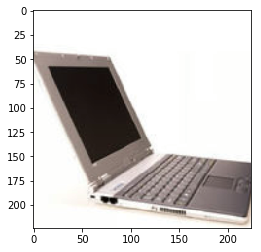

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[590 681 527 810 620]
tensor([0.0039, 0.6851, 0.0047, 0.0173, 0.2792], device='cuda:0')


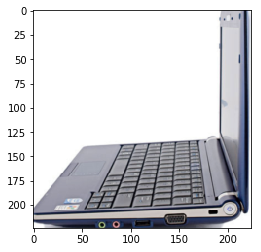

[662 681 620 590 810]
tensor([0.0166, 0.7702, 0.1285, 0.0294, 0.0210], device='cuda:0')


In [20]:
#check out confusion matrix for MAP
from sklearn.metrics import confusion_matrix

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                     std=[0.229, 0.224, 0.225])

def imshow(img):
    img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

targets = np.array(imagenet_val.targets)
_, pred = imagenet_MAP.max(1)
pred = pred.cpu()
cm = confusion_matrix(targets, pred)
np.fill_diagonal(cm, 0)

    
#get max index
max_idx = np.unravel_index(cm.argmax(), cm.shape)
print(max_idx)
print(cm[620, 681])
print(cm[681, 620])
idx_620 = np.where(targets==620)
idx_681 = np.where(targets==681)
#turns out that 620 is "laptop, laptop computer" and 681 is "notebook, notebook computer"
print("idx 620: ", idx_620)
print("idx 681: ", idx_681)
imshow(imagenet_val[31003][0])
top5_31003 = np.argpartition(imagenet_MAP[31003].cpu().numpy(), -5)[-5:]
print(top5_31003)
print(imagenet_MAP[31003][top5_31003])
imshow(imagenet_val[34054][0])
top5_34054 = np.argpartition(imagenet_MAP[34054].cpu().numpy(), -5)[-5:]
print(top5_34054)
print(imagenet_MAP[34054][top5_34054])

# check out DIR_LPA

In [21]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*mu), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    return(alpha)

In [22]:
@torch.no_grad()
def predict_DIR_LPA(model, test_loader, M_W_post, M_b_post, C_W_post, C_b_post, verbose=False, cuda=False):
    alphas = []

    max_len = len(test_loader)

    for batch_idx, (x, y) in enumerate(test_loader):
        
        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x).detach()

        mu_pred, Cov_pred = get_Gaussian_output(phi, M_W_post, M_b_post, C_W_post, C_b_post)

        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        #alpha /= alpha.sum(dim=1).view(-1,1).detach()

        alphas.append(alpha)


        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    return(torch.cat(alphas, dim = 0))

In [24]:
#"""
imagenet_DIR_LPA = predict_DIR_LPA(densenet, val_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, verbose=True, cuda=True)
targets = np.array(imagenet_val.targets)
prob_DIR_LPA, pred_DIR_LPA = imagenet_DIR_LPA.max(1)
pred_DIR_LPA = pred_DIR_LPA.cpu().numpy()
np.equal(targets, pred_DIR_LPA).mean()
#"""

Batch: 0/782
Batch: 1/782
Batch: 2/782
Batch: 3/782
Batch: 4/782
Batch: 5/782
Batch: 6/782
Batch: 7/782
Batch: 8/782
Batch: 9/782
Batch: 10/782
Batch: 11/782
Batch: 12/782
Batch: 13/782
Batch: 14/782
Batch: 15/782
Batch: 16/782
Batch: 17/782
Batch: 18/782
Batch: 19/782
Batch: 20/782
Batch: 21/782
Batch: 22/782
Batch: 23/782
Batch: 24/782
Batch: 25/782
Batch: 26/782
Batch: 27/782
Batch: 28/782
Batch: 29/782
Batch: 30/782
Batch: 31/782
Batch: 32/782
Batch: 33/782
Batch: 34/782
Batch: 35/782
Batch: 36/782
Batch: 37/782
Batch: 38/782
Batch: 39/782
Batch: 40/782
Batch: 41/782
Batch: 42/782
Batch: 43/782
Batch: 44/782
Batch: 45/782
Batch: 46/782
Batch: 47/782
Batch: 48/782
Batch: 49/782
Batch: 50/782
Batch: 51/782
Batch: 52/782
Batch: 53/782
Batch: 54/782
Batch: 55/782
Batch: 56/782
Batch: 57/782
Batch: 58/782
Batch: 59/782
Batch: 60/782
Batch: 61/782
Batch: 62/782
Batch: 63/782
Batch: 64/782
Batch: 65/782
Batch: 66/782
Batch: 67/782
Batch: 68/782
Batch: 69/782
Batch: 70/782
Batch: 71/782
Ba

Batch: 554/782
Batch: 555/782
Batch: 556/782
Batch: 557/782
Batch: 558/782
Batch: 559/782
Batch: 560/782
Batch: 561/782
Batch: 562/782
Batch: 563/782
Batch: 564/782
Batch: 565/782
Batch: 566/782
Batch: 567/782
Batch: 568/782
Batch: 569/782
Batch: 570/782
Batch: 571/782
Batch: 572/782
Batch: 573/782
Batch: 574/782
Batch: 575/782
Batch: 576/782
Batch: 577/782
Batch: 578/782
Batch: 579/782
Batch: 580/782
Batch: 581/782
Batch: 582/782
Batch: 583/782
Batch: 584/782
Batch: 585/782
Batch: 586/782
Batch: 587/782
Batch: 588/782
Batch: 589/782
Batch: 590/782
Batch: 591/782
Batch: 592/782
Batch: 593/782
Batch: 594/782
Batch: 595/782
Batch: 596/782
Batch: 597/782
Batch: 598/782
Batch: 599/782
Batch: 600/782
Batch: 601/782
Batch: 602/782
Batch: 603/782
Batch: 604/782
Batch: 605/782
Batch: 606/782
Batch: 607/782
Batch: 608/782
Batch: 609/782
Batch: 610/782
Batch: 611/782
Batch: 612/782
Batch: 613/782
Batch: 614/782
Batch: 615/782
Batch: 616/782
Batch: 617/782
Batch: 618/782
Batch: 619/782
Batch: 620

0.74252

In [25]:
#"""
imagenet_DIR_LPA_dict = {
    'imagenet_DIR_LPA':imagenet_DIR_LPA
}

IMAGENET_DIR_LPA_PATH = 'weights/imagenet_DIR_LPA_1e-10.pth'
torch.save(imagenet_DIR_LPA_dict, IMAGENET_DIR_LPA_PATH)
#"""

In [57]:
IMAGENET_DIR_LPA_PATH = 'weights/imagenet_DIR_LPA_1e-10.pth'
#IMAGENET_DIR_LPA_PATH = 'weights/imagenet_DIR_LPA.pth'
imagenet_DIR_LPA_dict = torch.load(IMAGENET_DIR_LPA_PATH)
imagenet_DIR_LPA = imagenet_DIR_LPA_dict['imagenet_DIR_LPA']
print(imagenet_DIR_LPA.size())

#check accuracy
targets = np.array(imagenet_val.targets)
prob_DIR_LPA, pred_DIR_LPA = imagenet_DIR_LPA.max(1)
pred_DIR_LPA = pred_DIR_LPA.cpu().numpy()
np.equal(targets, pred_DIR_LPA).mean()

torch.Size([50000, 1000])


0.74252

# show how uncertainty differs depending on Dirichlet or Softmax

In [58]:
def get_top5(pred):
    return(np.argpartition(pred.cpu().numpy(), -5)[-5:])


#11 & 12
#13 & 9
#15 & 6
#21 is interesting 
i = 11
top5_MAP_i = get_top5(imagenet_MAP[i])
top5_DIR_LPA_i = get_top5(imagenet_DIR_LPA[i])

print(top5_MAP_i)
print(top5_DIR_LPA_i)
print(imagenet_MAP[i][top5_MAP_i])
print(imagenet_DIR_LPA[i][top5_DIR_LPA_i])

[997 934 394 389   0]
[955 329 934 389   0]
tensor([3.8439e-06, 7.1111e-06, 4.7714e-06, 4.0531e-05, 9.9992e-01],
       device='cuda:0')
tensor([2.1536e+01, 2.2349e+01, 3.3098e+01, 1.5569e+02, 4.0279e+06],
       device='cuda:0')


a11, b11:  tensor(4027912.7500) tensor(3460.7500)
[997 934 394 389   0]
[955 329 934 389   0]
tensor([3.8439e-06, 7.1111e-06, 4.7714e-06, 4.0531e-05, 9.9992e-01],
       device='cuda:0')
tensor([2.1536e+01, 2.2349e+01, 3.3098e+01, 1.5569e+02, 4.0279e+06])


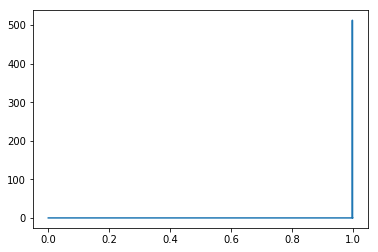

a12, b12:  tensor(13416834.) tensor(5224.)
[395 382 391 389   0]
[382 955 391 389   0]
tensor([9.4693e-07, 1.5510e-06, 1.3131e-05, 1.6527e-04, 9.9981e-01],
       device='cuda:0')
tensor([1.8969e+01, 2.3127e+01, 2.0963e+02, 2.1332e+03, 1.3417e+07])


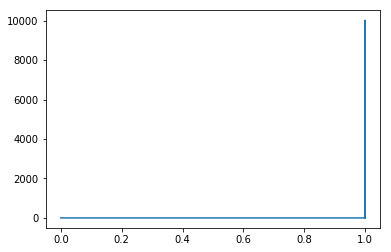

In [59]:
from scipy.stats import beta

imagenet_DIR_LPA = imagenet_DIR_LPA.cpu()

a11 = imagenet_DIR_LPA[11][0]
b11 = imagenet_DIR_LPA[11].sum() - a11
print("a11, b11: ", a11, b11)

top5_MAP_11 = get_top5(imagenet_MAP[11])
top5_DIR_LPA_11 = get_top5(imagenet_DIR_LPA[11])

print(top5_MAP_11)
print(top5_DIR_LPA_11)
print(imagenet_MAP[11][top5_MAP_11])
print(imagenet_DIR_LPA[11][top5_DIR_LPA_11])

x = np.linspace(0,1, 10000 + 1)
beta_11_pdf = beta.pdf(x, a=a11, b=b11)
plt.plot(x, beta_11_pdf)
plt.show()


a12 = imagenet_DIR_LPA[12][0]
b12 = imagenet_DIR_LPA[12].sum() - a12
print("a12, b12: ", a12, b12)

top5_MAP_12 = get_top5(imagenet_MAP[12])
top5_DIR_LPA_12 = get_top5(imagenet_DIR_LPA[12])

print(top5_MAP_12)
print(top5_DIR_LPA_12)
print(imagenet_MAP[12][top5_MAP_12])
print(imagenet_DIR_LPA[12][top5_DIR_LPA_12])

x = np.linspace(0,1, 10000 + 1)
beta_12_pdf = beta.pdf(x, a=a12, b=b12)
plt.plot(x, beta_12_pdf)
plt.show()

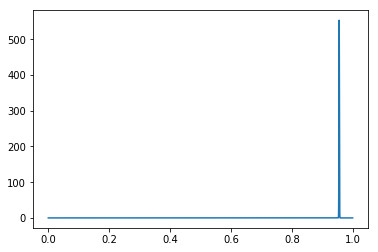

[395 758 391 389   0]
[363 389 391 758   0]
tensor([2.6679e-04, 3.9216e-04, 6.4811e-04, 7.3557e-03, 9.9019e-01],
       device='cuda:0')
tensor([4.2591e+01, 5.5181e+02, 6.1246e+01, 5.3198e+01, 7.7891e+04])
[955 395 391 389   0]
[395 955 391 389   0]
tensor([9.0603e-06, 3.5860e-05, 4.3053e-05, 4.8333e-03, 9.9505e-01],
       device='cuda:0')
tensor([6.9631e+01, 6.9970e+01, 1.1466e+02, 1.0468e+04, 2.5863e+06])


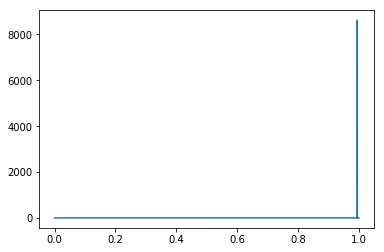

In [60]:
a9 = imagenet_DIR_LPA[9][0]
b9 = imagenet_DIR_LPA[9].sum() - a9

x = np.linspace(0,1, 10000 + 1)
beta_9_pdf = beta.pdf(x, a=a9, b=b9)
plt.plot(x, beta_9_pdf)
plt.show()

top5_MAP_9 = get_top5(imagenet_MAP[9])
top5_DIR_LPA_9 = get_top5(imagenet_DIR_LPA[9])

print(top5_MAP_9)
print(top5_DIR_LPA_9)
print(imagenet_MAP[9][top5_MAP_9])
print(imagenet_DIR_LPA[9][top5_DIR_LPA_9])

a13 = imagenet_DIR_LPA[13][0]
b13 = imagenet_DIR_LPA[13].sum() - a13

top5_MAP_13 = get_top5(imagenet_MAP[13])
top5_DIR_LPA_13 = get_top5(imagenet_DIR_LPA[13])

print(top5_MAP_13)
print(top5_DIR_LPA_13)
print(imagenet_MAP[13][top5_MAP_13])
print(imagenet_DIR_LPA[13][top5_DIR_LPA_13])

x = np.linspace(0,1, 10000 + 1)
beta_13_pdf = beta.pdf(x, a=a13, b=b13)
plt.plot(x, beta_13_pdf)
plt.show()

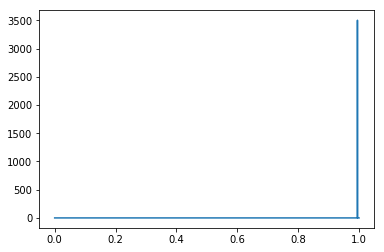

In [61]:
a21 = imagenet_DIR_LPA[21][0]
b21 = imagenet_DIR_LPA[21].sum() - a21

x = np.linspace(0,1, 10000 + 1)
beta_21_pdf = beta.pdf(x, a=a21, b=b21)
plt.plot(x, beta_21_pdf)
plt.show()

# check out class Laptop vs notebook to see how uncertainty is distributed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[527 810 620 662 681]
[590 662 323 681 620]
tensor([0.0184, 0.0310, 0.3916, 0.0353, 0.4327], device='cuda:0')
tensor([ 30.6724,  34.1187,  34.9909, 296.0610, 307.7745])


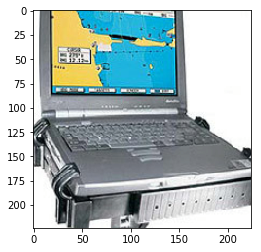

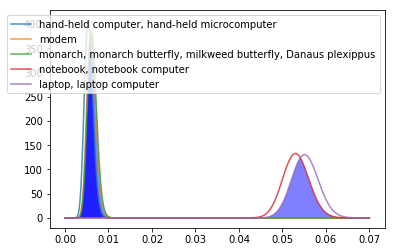

In [123]:
def get_topK(pred, k):
    return(np.argpartition(pred.cpu().numpy(), -k)[-k:])

i = 31036
k = 5
topK_MAP_i = get_topK(imagenet_MAP[i], k)
topK_DIR_LPA_i = get_topK(imagenet_DIR_LPA[i], k)

# example for no clear winner:
# 31000, 31001, 04, 25

# example for a clear winner:
# 31002, 03, 08, 09, 49

# example for high uncertainty w.r.t the winner
# 31010, 15, 19, 28, 29, 32, 36

# generally fascinating:
# 31017

print(topK_MAP_i)
print(topK_DIR_LPA_i)
print(imagenet_MAP[i][topK_MAP_i])
print(imagenet_DIR_LPA[i][topK_DIR_LPA_i])

imshow(imagenet_val[i][0])

def fill_below_intersection(x, S, Z):
    """
    fill the region below the intersection of S and Z
    """
    #find the intersection point
    min_ = np.amin(np.stack((S, Z)), axis=0)
    plt.fill(x, min_, facecolor='blue', alpha=0.5)

def plot_beta_top_K(i, k=5):
    
    x = np.linspace(0,1, 10000 + 1)
    #topK_MAP_i = get_topK(imagenet_MAP[i], k)
    topK_idx = get_topK(imagenet_DIR_LPA[i], k)
    alpha_sum = imagenet_DIR_LPA[i].sum()
    topK_alphas = imagenet_DIR_LPA[i][topK_idx]
    right_boarder = 0
    beta_dists = []
    for j, a_x in enumerate(topK_alphas):
        b_x = alpha_sum - a_x 
        beta_x_pdf = beta.pdf(x, a=a_x, b=b_x)
        beta_dists.append(beta_x_pdf)
        if np.argmax(beta_x_pdf) > right_boarder:
            right_boarder = np.argmax(beta_x_pdf)
    
    for j in range(k):
        plt.plot(x[:right_boarder + 150], beta_dists[j][:right_boarder + 150], \
                 label='{}'.format(label_dict[topK_idx[j]]), alpha=0.8)
        
    for j, b1 in enumerate(beta_dists):
        for k, b2 in enumerate(beta_dists):
            if k>j:
                rb = right_boarder + 150
                fill_below_intersection(x[:rb], b1[:rb], b2[:rb])
    plt.legend()
    plt.show()
    
plot_beta_top_K(i, k=k)

In [35]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def imshow(img):
    img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def make_combined_plot(idx1, idx2, filename, show_MAP=False):
    
    top5_MAP_idx1 = get_top5(imagenet_MAP[idx1])
    top5_DIR_LPA_idx1 = get_top5(imagenet_DIR_LPA[idx1])
    top5_MAP_idx2 = get_top5(imagenet_MAP[idx2])
    top5_DIR_LPA_idx2 = get_top5(imagenet_DIR_LPA[idx2])
    top5_MAP1 = imagenet_MAP[idx1][top5_MAP_idx1]
    top5_MAP1_class = top5_MAP_idx1[top5_MAP1.argmax()]
    top5_MAP2 = imagenet_MAP[idx2][top5_MAP_idx2]
    top5_MAP2_class = top5_MAP_idx2[top5_MAP2.argmax()]
    
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(15, 15))
    
    img_idx1 = unnormalize(imagenet_val[idx1][0])
    img_idx2 = unnormalize(imagenet_val[idx2][0])
    
    axs[0][0].imshow(np.transpose(img_idx1.numpy(), (1, 2, 0)))
    axs[0][0].axis('off')
    axs[0][1].imshow(np.transpose(img_idx2.numpy(), (1, 2, 0)))
    axs[0][1].axis('off')
    
    x = np.linspace(0,1, 10000 + 1)
    #idx1 beta
    alpha_sum1 = imagenet_DIR_LPA[idx1].sum()
    top5_alphas1 = imagenet_DIR_LPA[idx1][top5_DIR_LPA_idx1]
    max_beta1 = 0
    for j, a_x in enumerate(top5_alphas1):
        b_x = alpha_sum1 - a_x 
        beta_x_pdf1 = beta.pdf(x, a=a_x, b=b_x)
        if max(beta_x_pdf1) > max_beta1:
            max_beta1 = max(beta_x_pdf1)
        axs[1][0].plot(x, beta_x_pdf1, label='{}'.format(label_dict[top5_DIR_LPA_idx1[j]]), alpha=0.8)

    if show_MAP:  
        axs[1][0].plot(2*[max(top5_MAP1)], [0, max_beta1], 'r--', label="MAP for {}".format(label_dict[top5_MAP1_class]));
    axs[1][0].legend(prop={'size': 13})    
    
    #idx2 beta
    max_beta2 = 0
    alpha_sum2 = imagenet_DIR_LPA[idx2].sum()
    top5_alphas2 = imagenet_DIR_LPA[idx2][top5_DIR_LPA_idx2]
    for j, a_x in enumerate(top5_alphas2):
        b_x = alpha_sum2 - a_x 
        beta_x_pdf2 = beta.pdf(x, a=a_x, b=b_x)
        if max(beta_x_pdf2) > max_beta2:
            max_beta2 = max(beta_x_pdf2)
        axs[1][1].plot(x, beta_x_pdf2, label='{}'.format(label_dict[top5_DIR_LPA_idx2[j]]), alpha=0.8)
    
    if show_MAP:
        axs[1][1].plot(2*[max(top5_MAP2)], [0, max_beta2], 'r--', label="MAP for {}".format(label_dict[top5_MAP2_class]));
    axs[1][1].legend(prop={'size': 13})    
       
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [150]:
import tikzplotlib as tpl

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def imshow(img):
    img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def fill_below_intersection(x, S, Z):
    """
    fill the region below the intersection of S and Z
    """
    #find the intersection point
    min_ = np.amin(np.stack((S, Z)), axis=0)
    plt.fill(x, min_, facecolor='blue', alpha=0.5)
    
# just show the images
def show_images(list_of_idx, filename):
    
    n = len(list_of_idx)
    fig, axs = plt.subplots(nrows=1, ncols=n, sharex=False, figsize=(n*6, 6))
    
    for i, idx in enumerate(list_of_idx):
        img = unnormalize(imagenet_val[idx][0])
        axs[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axs[i].axis('off')
        
    plt.tight_layout()
    plt.savefig('figures/{}'.format(filename))
    plt.show()
    
#show the beta distributions of the topK estimates
def show_beta_marginals(list_of_idx, list_of_k, filename):
    
    n = len(list_of_idx)
    fig, axs = plt.subplots(nrows=1, ncols=n, sharex=False, figsize=(n*6, 6))
    
    x = np.linspace(0,1, 10000 + 1)
    C = 150
    for i, idx in enumerate(list_of_idx):
        
        k = ks[i]
        topK_idx = get_topK(imagenet_DIR_LPA[idx], k)
        alpha_sum = imagenet_DIR_LPA[idx].sum()
        topK_alphas = imagenet_DIR_LPA[idx][topK_idx]
        right_boarder = 0
        beta_dists = []
        for j, a_x in enumerate(topK_alphas):
            b_x = alpha_sum - a_x 
            beta_x_pdf = beta.pdf(x, a=a_x, b=b_x)
            beta_dists.append(beta_x_pdf)
            if np.argmax(beta_x_pdf) > right_boarder:
                right_boarder = np.argmax(beta_x_pdf)

        for j in range(k):
            label_string = label_dict[topK_idx[j]]
            label_string = ' '.join(label_string.split(',')[:1])
            axs[i].plot(x[:right_boarder + C], beta_dists[j][:right_boarder + C], \
                     label='{}'.format(label_string), alpha=0.8)

        for j, b1 in enumerate(beta_dists):
            for j2, b2 in enumerate(beta_dists):
                if j2>j:
                    rb = right_boarder + C
                    #fill_below_intersection(x[:rb], b1[:rb], b2[:rb])
                    """
                    fill the region below the intersection of S and Z
                    """
                    #find the intersection point
                    min_ = np.amin(np.stack((b1[:rb], b2[:rb])), axis=0)
                    axs[i].fill(x[:rb], min_, facecolor='blue', alpha=0.5)
                    
        axs[i].legend()
    
    tpl.save('figures/{}'.format(filename), figure=fig, figurewidth='\\figwidth', figureheight='\\figheight')
    plt.show()
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


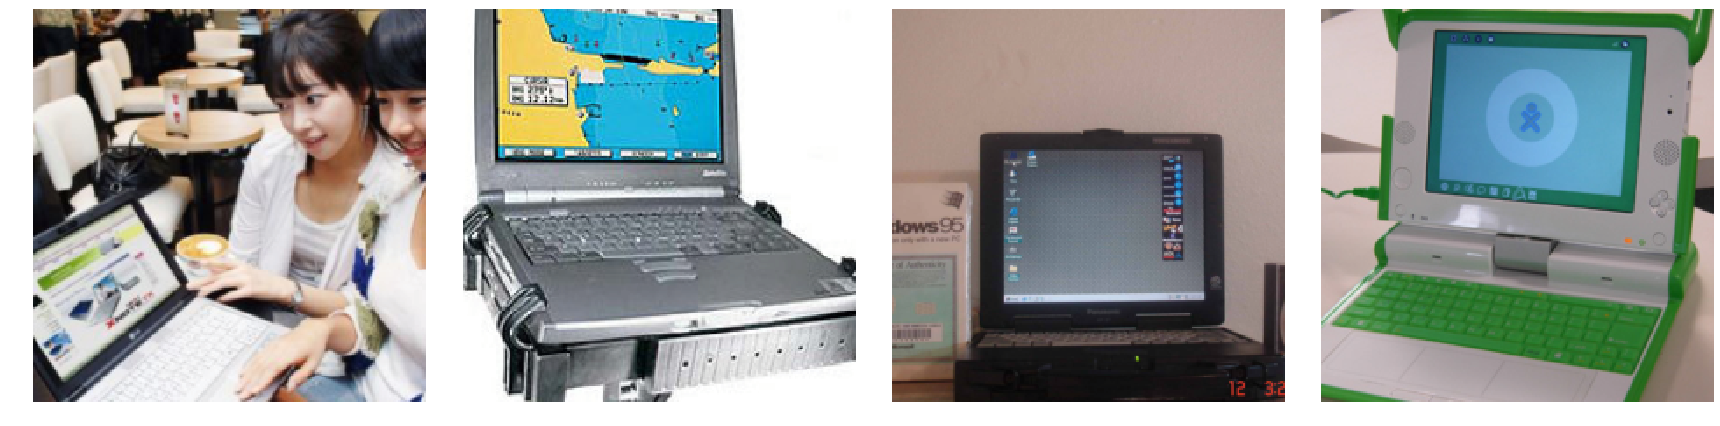

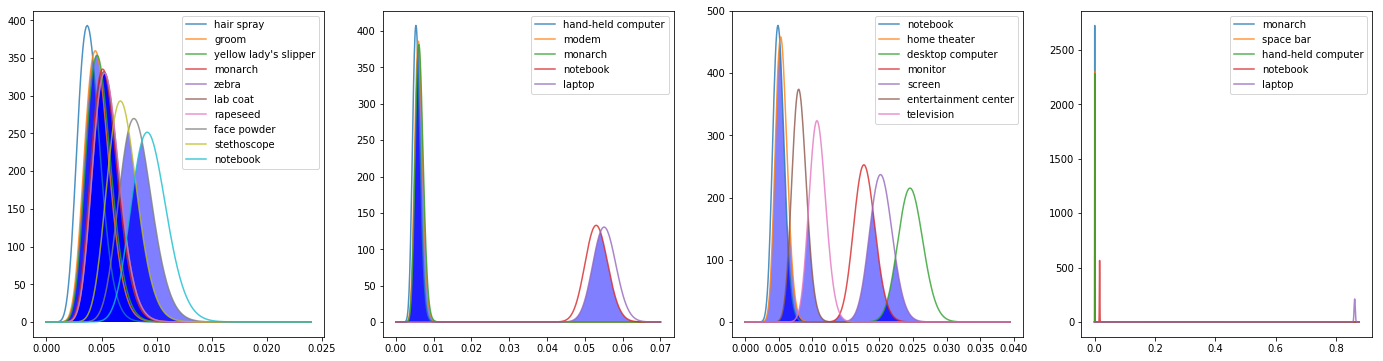

In [153]:
idxs = [31000, 31036, 31028, 31009]
ks = [10,5,7,5]
show_images(idxs, filename='imagenet_images.pdf')
show_beta_marginals(idxs, ks, filename='imagenet_marginal_betas.tex')

# big plot for same MAP

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


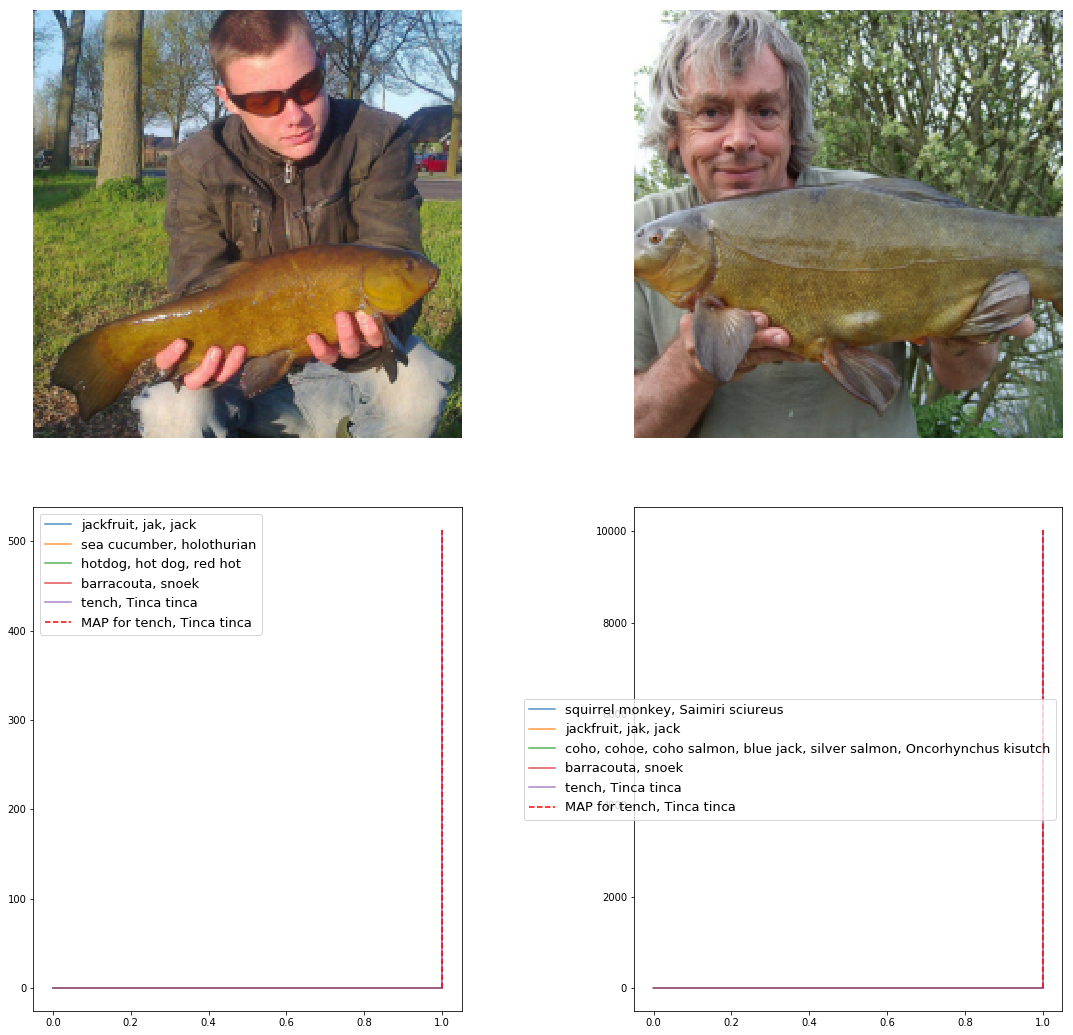

In [36]:
make_combined_plot(11, 12, filename="figures/same_MAP.pdf", show_MAP=True)

# big plot for new top5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


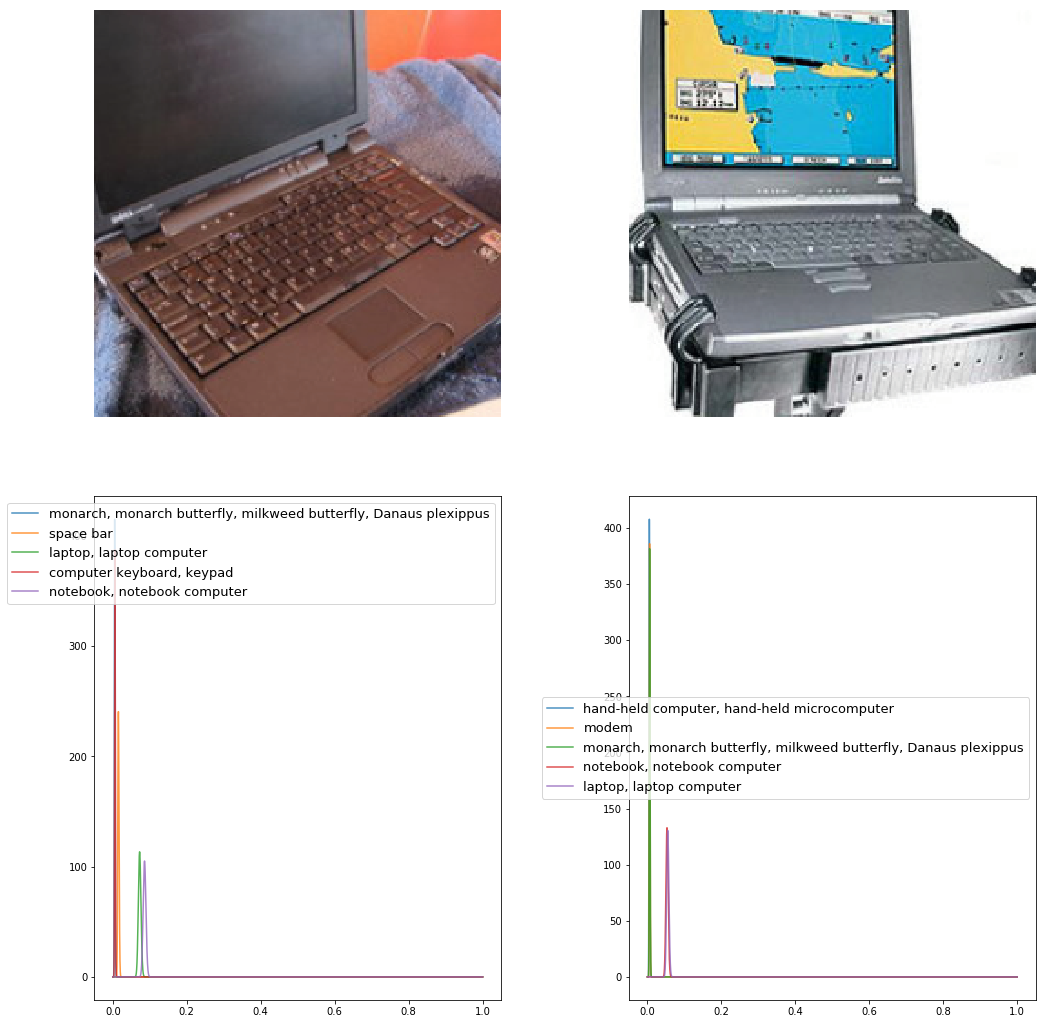

In [37]:
make_combined_plot(31010, 31036, filename="figures/topk_replacement.pdf")

In [33]:
label_dict = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}